# Medical Image Classification

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
import monai.networks.nets as nets
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.25.0
scipy version: 1.15.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.48.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

In [261]:
seed = 4
np.random.seed(seed)

## Continue working with OrganMNIST3d 64x64x64

In [262]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 20
BATCH_SIZE = 8
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [263]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [264]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [265]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [266]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        volume, label = self.dataset[idx]
        volume = torch.tensor(volume, dtype=torch.float32)

        axial, coronal, sagittal = self.extract_2d_slices(volume)

        if self.transform:
            axial = self.transform(axial)
            coronal = self.transform(coronal)
            sagittal = self.transform(sagittal)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(volume):
        axial = volume.permute(1, 0, 2, 3).flatten(0, 1)
        coronal = volume.permute(2, 0, 1, 3).flatten(0, 1)
        sagittal = volume.permute(3, 0, 1, 2).flatten(0, 1)

        return axial, sagittal, coronal


In [267]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

In [185]:
idx = np.random.choice(train_dataset_.__len__(), size=10, replace=False)

idx

array([925, 721, 146, 456, 284, 419, 606, 343, 226, 513])

In [98]:
def show_slice(dataset, idx):

    fig, axs = plt.subplots(3,10)

    for i, index in enumerate(idx):
        x1, x2, x3 = dataset[index]['images']
        y = dataset[index]['label']

        ax = axs[0, i]
        ax.imshow(x1[0][1].numpy(), cmap='gray')
        ax.set_title(f'{y}')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[1, i]
        ax.imshow(x2[0][1].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[2, i]
        ax.imshow(x3[0][1].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.axis('off')
    plt.figure(figsize=(7,15))
    plt.show()

TypeError: Invalid shape (64,) for image data

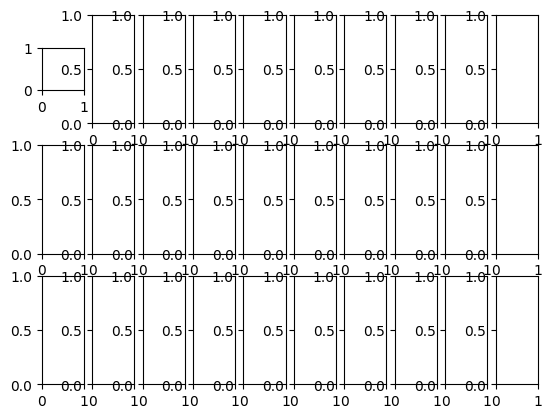

In [99]:
show_slice(train_dataset_, idx)

In [ ]:
def montage(dataset, length=20, replace=False, save_folder='dataset', flag = 'axial'):
    from medmnist.utils import montage2d

    imgs = []

    n_sel = length * length
    sel = np.random.choice(dataset.__len__(), size=n_sel, replace=replace)
    
    if flag == 'axial':
        slice_ = 0
    elif flag == 'coronal':
        slice_ = 1
    else:
        slice_ = 2
    
    for idx in sel:
        imgs.append((dataset[idx]['images'][slice_]*255).astype(np.uint8))
        
    montage_img = montage2d(np.array(imgs)[:, 0],
                            n_channels=n_channels,
                            sel=range(0, n_sel))
    
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        montage_img.save(os.path.join(save_folder,
                                        f"{data_flag}{flag}_montage.png"))

    return montage_img

In [ ]:
montage(train_dataset_, length=20, replace=False, flag = 'axial')

In [ ]:
montage(train_dataset_, length=20, replace=False, flag = 'coronal')

In [ ]:
montage(train_dataset_, length=20, replace=False, flag = 'sagittal')

# Axial part

## Pretrained

In [268]:
auc_metric = ROCAUCMetric()

In [269]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [270]:
print(model)

ResNet(
  (conv1): Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [271]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images

        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "axial_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 1.8976
1


Epochs:   2%|▎         | 1/40 [00:17<11:19, 17.42s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9671 current accuracy: 0.7267 best AUC: 0.9671 at epoch: 1
----------
epoch 2/40
epoch 2 average loss: 1.1276
1


Epochs:   5%|▌         | 2/40 [00:34<11:04, 17.48s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9882 current accuracy: 0.9006 best AUC: 0.9882 at epoch: 2
----------
epoch 3/40
epoch 3 average loss: 0.8522
1


Epochs:   8%|▊         | 3/40 [00:52<10:44, 17.41s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9979 current accuracy: 0.9565 best AUC: 0.9979 at epoch: 3
----------
epoch 4/40
epoch 4 average loss: 0.6445
1


Epochs:  10%|█         | 4/40 [01:09<10:23, 17.33s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9980 current accuracy: 0.9565 best AUC: 0.9980 at epoch: 4
----------
epoch 5/40
epoch 5 average loss: 0.5525
1


Epochs:  12%|█▎        | 5/40 [01:26<10:06, 17.33s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9995 current accuracy: 0.9689 best AUC: 0.9995 at epoch: 5
----------
epoch 6/40
epoch 6 average loss: 0.5015
1


Epochs:  15%|█▌        | 6/40 [01:44<09:49, 17.34s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9995 current accuracy: 0.9689 best AUC: 0.9995 at epoch: 6
----------
epoch 7/40
epoch 7 average loss: 0.4432


Epochs:  18%|█▊        | 7/40 [02:01<09:26, 17.18s/it]

1
current epoch: 7 current AUC: 0.9988 current accuracy: 0.9752 best AUC: 0.9995 at epoch: 6
----------
epoch 8/40
epoch 8 average loss: 0.3463
1


Epochs:  20%|██        | 8/40 [02:18<09:13, 17.28s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9996 current accuracy: 0.9938 best AUC: 0.9996 at epoch: 8
----------
epoch 9/40
epoch 9 average loss: 0.3485
1


Epochs:  22%|██▎       | 9/40 [02:35<08:55, 17.29s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 0.9999 at epoch: 9
----------
epoch 10/40
epoch 10 average loss: 0.3359


Epochs:  25%|██▌       | 10/40 [02:52<08:35, 17.19s/it]

1
current epoch: 10 current AUC: 0.9995 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 9
----------
epoch 11/40
epoch 11 average loss: 0.2734


Epochs:  28%|██▊       | 11/40 [03:09<08:16, 17.11s/it]

1
current epoch: 11 current AUC: 0.9992 current accuracy: 0.9752 best AUC: 0.9999 at epoch: 9
----------
epoch 12/40
epoch 12 average loss: 0.2625


Epochs:  30%|███       | 12/40 [03:26<07:58, 17.11s/it]

1
current epoch: 12 current AUC: 0.9996 current accuracy: 0.9876 best AUC: 0.9999 at epoch: 9
----------
epoch 13/40
epoch 13 average loss: 0.2281


Epochs:  32%|███▎      | 13/40 [03:43<07:39, 17.00s/it]

1
current epoch: 13 current AUC: 0.9993 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 9
----------
epoch 14/40
epoch 14 average loss: 0.2328
1


Epochs:  35%|███▌      | 14/40 [04:00<07:24, 17.11s/it]

saved new best metric model
current epoch: 14 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 0.9999 at epoch: 14
----------
epoch 15/40
epoch 15 average loss: 0.2151


Epochs:  38%|███▊      | 15/40 [04:17<07:04, 16.99s/it]

1
current epoch: 15 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 0.9999 at epoch: 14
----------
epoch 16/40
epoch 16 average loss: 0.1826
1


Epochs:  40%|████      | 16/40 [04:34<06:49, 17.08s/it]

saved new best metric model
current epoch: 16 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 17/40
epoch 17 average loss: 0.1518


Epochs:  42%|████▎     | 17/40 [04:51<06:32, 17.06s/it]

1
current epoch: 17 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 18/40
epoch 18 average loss: 0.1953


Epochs:  45%|████▌     | 18/40 [05:08<06:13, 16.97s/it]

1
current epoch: 18 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 16
----------
epoch 19/40
epoch 19 average loss: 0.1264


Epochs:  48%|████▊     | 19/40 [05:25<05:56, 16.99s/it]

1
current epoch: 19 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 16
----------
epoch 20/40
epoch 20 average loss: 0.1524


Epochs:  50%|█████     | 20/40 [05:42<05:40, 17.01s/it]

1
current epoch: 20 current AUC: 0.9992 current accuracy: 0.9441 best AUC: 1.0000 at epoch: 16
----------
epoch 21/40
epoch 21 average loss: 0.1407


Epochs:  52%|█████▎    | 21/40 [05:59<05:22, 16.96s/it]

1
current epoch: 21 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 16
----------
epoch 22/40
epoch 22 average loss: 0.1706


Epochs:  55%|█████▌    | 22/40 [06:16<05:04, 16.90s/it]

1
current epoch: 22 current AUC: 0.9999 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 23/40
epoch 23 average loss: 0.1484


Epochs:  57%|█████▊    | 23/40 [06:33<04:46, 16.87s/it]

1
current epoch: 23 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 16
----------
epoch 24/40
epoch 24 average loss: 0.1104


Epochs:  60%|██████    | 24/40 [06:50<04:30, 16.91s/it]

1
current epoch: 24 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 16
----------
epoch 25/40
epoch 25 average loss: 0.1101


Epochs:  62%|██████▎   | 25/40 [07:07<04:13, 16.91s/it]

1
current epoch: 25 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 26/40
epoch 26 average loss: 0.1136


Epochs:  65%|██████▌   | 26/40 [07:24<03:56, 16.90s/it]

1
current epoch: 26 current AUC: 0.9998 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 16
----------
epoch 27/40
epoch 27 average loss: 0.0944


Epochs:  68%|██████▊   | 27/40 [07:40<03:39, 16.91s/it]

1
current epoch: 27 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 28/40
epoch 28 average loss: 0.1110


Epochs:  70%|███████   | 28/40 [07:57<03:23, 16.93s/it]

1
current epoch: 28 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 16
----------
epoch 29/40
epoch 29 average loss: 0.0761


Epochs:  72%|███████▎  | 29/40 [08:14<03:06, 16.93s/it]

1
current epoch: 29 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 30/40
epoch 30 average loss: 0.1087


Epochs:  75%|███████▌  | 30/40 [08:31<02:48, 16.85s/it]

1
current epoch: 30 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 16
----------
epoch 31/40
epoch 31 average loss: 0.0954


Epochs:  78%|███████▊  | 31/40 [08:48<02:31, 16.82s/it]

1
current epoch: 31 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 16
----------
epoch 32/40
epoch 32 average loss: 0.0970


Epochs:  80%|████████  | 32/40 [09:05<02:14, 16.86s/it]

1
current epoch: 32 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 16
----------
epoch 33/40
epoch 33 average loss: 0.0869


Epochs:  82%|████████▎ | 33/40 [09:22<01:58, 16.87s/it]

1
current epoch: 33 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 34/40
epoch 34 average loss: 0.0715


Epochs:  85%|████████▌ | 34/40 [09:39<01:41, 16.96s/it]

1
current epoch: 34 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 35/40
epoch 35 average loss: 0.0958


Epochs:  88%|████████▊ | 35/40 [09:56<01:24, 16.96s/it]

1
current epoch: 35 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 16
----------
epoch 36/40
epoch 36 average loss: 0.0455


Epochs:  90%|█████████ | 36/40 [10:13<01:07, 16.93s/it]

1
current epoch: 36 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 37/40
epoch 37 average loss: 0.0675


Epochs:  92%|█████████▎| 37/40 [10:29<00:50, 16.89s/it]

1
current epoch: 37 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 38/40
epoch 38 average loss: 0.0620


Epochs:  95%|█████████▌| 38/40 [10:46<00:33, 16.86s/it]

1
current epoch: 38 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 39/40
epoch 39 average loss: 0.0560


Epochs:  98%|█████████▊| 39/40 [11:03<00:16, 16.93s/it]

1
current epoch: 39 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
----------
epoch 40/40
epoch 40 average loss: 0.0626


Epochs: 100%|██████████| 40/40 [11:20<00:00, 17.02s/it]

1
current epoch: 40 current AUC: 0.9999 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 16
train completed, best_metric: 1.0000 at epoch: 16


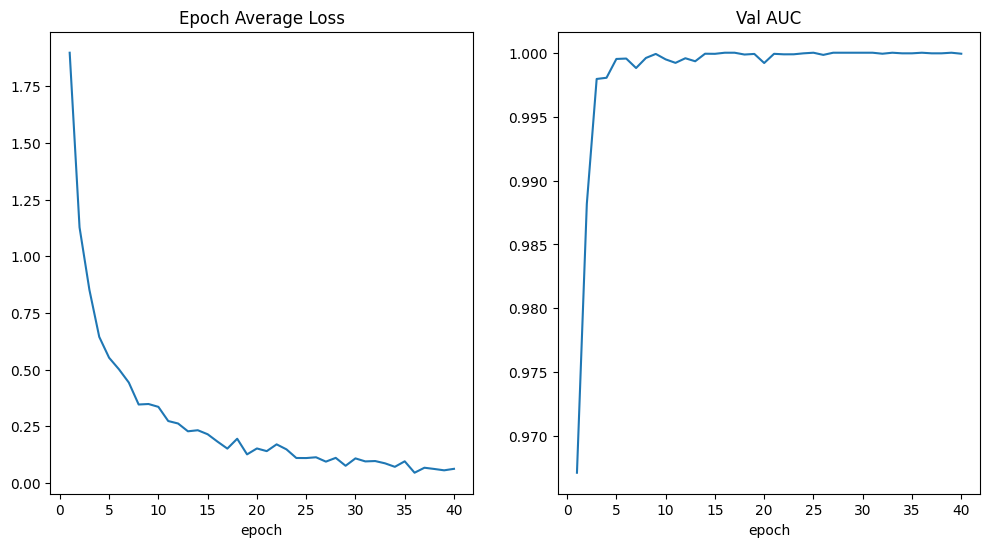

In [272]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [273]:
model.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [274]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)

In [275]:
import pandas as pd
df = pd.DataFrame(report).transpose()
df.to_csv(f'axial_full_pretrained_seed{seed}.csv')

In [276]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9855    0.9855    0.9855        69
           1     0.7975    0.9265    0.8571        68
           2     0.8909    0.7101    0.7903        69
           3     0.8219    0.9231    0.8696        65
           4     0.9474    0.8308    0.8852        65
           5     0.7949    0.9394    0.8611        66
           6     0.9630    0.9286    0.9455        28
           7     1.0000    1.0000    1.0000        21
           8     0.9545    1.0000    0.9767        21
           9     0.9683    0.8841    0.9242        69
          10     0.8939    0.8551    0.8741        69

    accuracy                         0.8918       610
   macro avg     0.9107    0.9076    0.9063       610
weighted avg     0.8978    0.8918    0.8914       610



## Unpretrained

In [277]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1
auc_metric = ROCAUCMetric()

In [278]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images

        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "axial_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 1.8063
1


Epochs:   2%|▎         | 1/40 [00:17<11:21, 17.48s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9835 current accuracy: 0.8137 best AUC: 0.9835 at epoch: 1
----------
epoch 2/40
epoch 2 average loss: 1.0830
1


Epochs:   5%|▌         | 2/40 [00:34<10:59, 17.34s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9970 current accuracy: 0.9068 best AUC: 0.9970 at epoch: 2
----------
epoch 3/40
epoch 3 average loss: 0.7518
1


Epochs:   8%|▊         | 3/40 [00:52<10:40, 17.31s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9998 current accuracy: 0.9752 best AUC: 0.9998 at epoch: 3
----------
epoch 4/40
epoch 4 average loss: 0.6339


Epochs:  10%|█         | 4/40 [01:08<10:17, 17.16s/it]

1
current epoch: 4 current AUC: 0.9997 current accuracy: 0.9565 best AUC: 0.9998 at epoch: 3
----------
epoch 5/40
epoch 5 average loss: 0.5131


Epochs:  12%|█▎        | 5/40 [01:26<10:01, 17.19s/it]

1
current epoch: 5 current AUC: 0.9985 current accuracy: 0.9317 best AUC: 0.9998 at epoch: 3
----------
epoch 6/40
epoch 6 average loss: 0.4840
1


Epochs:  15%|█▌        | 6/40 [01:43<09:47, 17.28s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 0.9998 at epoch: 6
----------
epoch 7/40
epoch 7 average loss: 0.4373
1


Epochs:  18%|█▊        | 7/40 [02:01<09:33, 17.37s/it]

saved new best metric model
current epoch: 7 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 7
----------
epoch 8/40
epoch 8 average loss: 0.3794


Epochs:  20%|██        | 8/40 [02:18<09:13, 17.28s/it]

1
current epoch: 8 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 7
----------
epoch 9/40
epoch 9 average loss: 0.3513


Epochs:  22%|██▎       | 9/40 [02:35<08:53, 17.20s/it]

1
current epoch: 9 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 7
----------
epoch 10/40
epoch 10 average loss: 0.3238


Epochs:  25%|██▌       | 10/40 [02:52<08:34, 17.15s/it]

1
current epoch: 10 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 7
----------
epoch 11/40
epoch 11 average loss: 0.2837


Epochs:  28%|██▊       | 11/40 [03:09<08:15, 17.08s/it]

1
current epoch: 11 current AUC: 0.9995 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 7
----------
epoch 12/40
epoch 12 average loss: 0.2612


Epochs:  30%|███       | 12/40 [03:26<07:56, 17.03s/it]

1
current epoch: 12 current AUC: 0.9997 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 7
----------
epoch 13/40
epoch 13 average loss: 0.2138


Epochs:  32%|███▎      | 13/40 [03:43<07:39, 17.02s/it]

1
current epoch: 13 current AUC: 0.9998 current accuracy: 0.9503 best AUC: 1.0000 at epoch: 7
----------
epoch 14/40
epoch 14 average loss: 0.1775


Epochs:  35%|███▌      | 14/40 [04:00<07:22, 17.01s/it]

1
current epoch: 14 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 7
----------
epoch 15/40
epoch 15 average loss: 0.2195


Epochs:  38%|███▊      | 15/40 [04:17<07:04, 16.98s/it]

1
current epoch: 15 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 7
----------
epoch 16/40
epoch 16 average loss: 0.1779


Epochs:  40%|████      | 16/40 [04:34<06:47, 16.98s/it]

1
current epoch: 16 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 7
----------
epoch 17/40
epoch 17 average loss: 0.1911


Epochs:  42%|████▎     | 17/40 [04:50<06:30, 16.97s/it]

1
current epoch: 17 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 7
----------
epoch 18/40
epoch 18 average loss: 0.1405


Epochs:  45%|████▌     | 18/40 [05:07<06:11, 16.87s/it]

1
current epoch: 18 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 7
----------
epoch 19/40
epoch 19 average loss: 0.1562


Epochs:  48%|████▊     | 19/40 [05:24<05:55, 16.91s/it]

1
current epoch: 19 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 7
----------
epoch 20/40
epoch 20 average loss: 0.2179


Epochs:  50%|█████     | 20/40 [05:41<05:38, 16.90s/it]

1
current epoch: 20 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 7
----------
epoch 21/40
epoch 21 average loss: 0.1446


Epochs:  52%|█████▎    | 21/40 [05:58<05:22, 16.99s/it]

1
current epoch: 21 current AUC: 0.9975 current accuracy: 0.9503 best AUC: 1.0000 at epoch: 7
----------
epoch 22/40
epoch 22 average loss: 0.1792


Epochs:  55%|█████▌    | 22/40 [06:15<05:06, 17.05s/it]

1
current epoch: 22 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 7
----------
epoch 23/40
epoch 23 average loss: 0.1241


Epochs:  57%|█████▊    | 23/40 [06:32<04:48, 16.98s/it]

1
current epoch: 23 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 7
----------
epoch 24/40
epoch 24 average loss: 0.1163


Epochs:  60%|██████    | 24/40 [06:49<04:31, 16.96s/it]

1
current epoch: 24 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 7
----------
epoch 25/40
epoch 25 average loss: 0.1339


Epochs:  62%|██████▎   | 25/40 [07:06<04:14, 16.97s/it]

1
current epoch: 25 current AUC: 0.9973 current accuracy: 0.9068 best AUC: 1.0000 at epoch: 7
----------
epoch 26/40
epoch 26 average loss: 0.1317


Epochs:  65%|██████▌   | 26/40 [07:23<03:57, 16.98s/it]

1
current epoch: 26 current AUC: 0.9998 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 7
----------
epoch 27/40
epoch 27 average loss: 0.0962


Epochs:  68%|██████▊   | 27/40 [07:40<03:40, 16.97s/it]

1
current epoch: 27 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 7
----------
epoch 28/40
epoch 28 average loss: 0.0935


Epochs:  70%|███████   | 28/40 [07:57<03:23, 16.92s/it]

1
current epoch: 28 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 7
----------
epoch 29/40
epoch 29 average loss: 0.0967


Epochs:  72%|███████▎  | 29/40 [08:14<03:05, 16.87s/it]

1
current epoch: 29 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 7
----------
epoch 30/40
epoch 30 average loss: 0.0933


Epochs:  75%|███████▌  | 30/40 [08:31<02:49, 16.92s/it]

1
current epoch: 30 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 7
----------
epoch 31/40
epoch 31 average loss: 0.1182


Epochs:  78%|███████▊  | 31/40 [08:48<02:32, 16.94s/it]

1
current epoch: 31 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 7
----------
epoch 32/40
epoch 32 average loss: 0.0798


Epochs:  80%|████████  | 32/40 [09:05<02:15, 16.93s/it]

1
current epoch: 32 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 7
----------
epoch 33/40
epoch 33 average loss: 0.0723


Epochs:  82%|████████▎ | 33/40 [09:21<01:58, 16.93s/it]

1
current epoch: 33 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 7
----------
epoch 34/40
epoch 34 average loss: 0.1049


Epochs:  85%|████████▌ | 34/40 [09:38<01:41, 16.91s/it]

1
current epoch: 34 current AUC: 0.9998 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 7
----------
epoch 35/40
epoch 35 average loss: 0.0912


Epochs:  88%|████████▊ | 35/40 [09:55<01:24, 16.93s/it]

1
current epoch: 35 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 7
----------
epoch 36/40
epoch 36 average loss: 0.0631


Epochs:  90%|█████████ | 36/40 [10:12<01:07, 16.98s/it]

1
current epoch: 36 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 7
----------
epoch 37/40
epoch 37 average loss: 0.0573


Epochs:  92%|█████████▎| 37/40 [10:29<00:50, 16.95s/it]

1
current epoch: 37 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 7
----------
epoch 38/40
epoch 38 average loss: 0.0737


Epochs:  95%|█████████▌| 38/40 [10:46<00:33, 16.98s/it]

1
current epoch: 38 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 7
----------
epoch 39/40
epoch 39 average loss: 0.0645


Epochs:  98%|█████████▊| 39/40 [11:04<00:17, 17.04s/it]

1
current epoch: 39 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 7
----------
epoch 40/40
epoch 40 average loss: 0.0660


Epochs: 100%|██████████| 40/40 [11:20<00:00, 17.02s/it]

1
current epoch: 40 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 7
train completed, best_metric: 1.0000 at epoch: 7


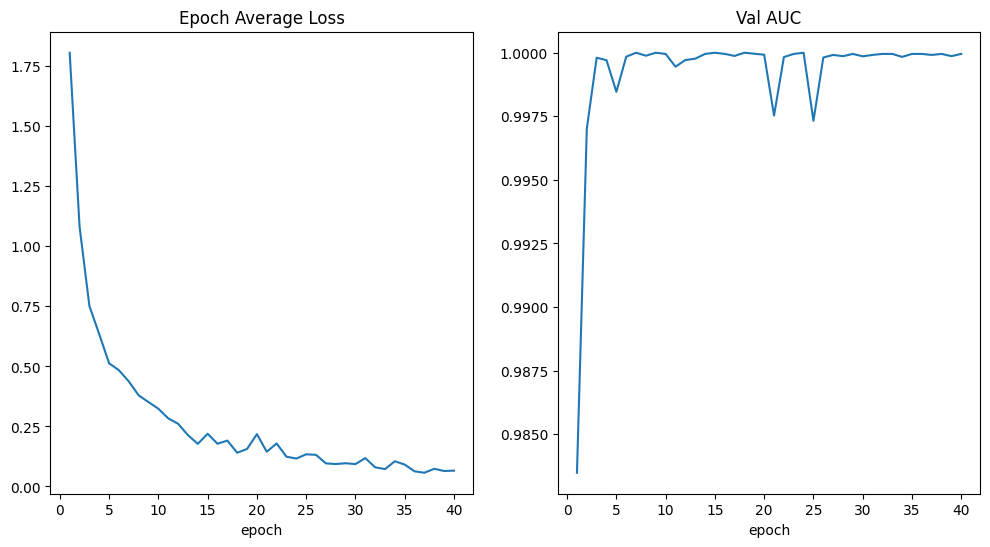

In [279]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [280]:
model.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [281]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)

In [282]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'axial_full_unpretrained_seed{seed}.csv')

In [283]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        69
           1     0.6842    0.7647    0.7222        68
           2     0.6897    0.5797    0.6299        69
           3     0.8113    0.6615    0.7288        65
           4     0.9200    0.7077    0.8000        65
           5     0.8636    0.8636    0.8636        66
           6     0.9630    0.9286    0.9455        28
           7     0.6774    1.0000    0.8077        21
           8     0.8400    1.0000    0.9130        21
           9     0.9492    0.8116    0.8750        69
          10     0.6875    0.9565    0.8000        69

    accuracy                         0.8148       610
   macro avg     0.8260    0.8431    0.8260       610
weighted avg     0.8269    0.8148    0.8133       610



# Coronal and sagittal parts

## Training cycle for the coronal part

## Pretrained

In [284]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [285]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "coronal_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 2.0003
1


Epochs:   2%|▎         | 1/40 [00:17<11:23, 17.53s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9479 current accuracy: 0.6273 best AUC: 0.9479 at epoch: 1
----------
epoch 2/40
epoch 2 average loss: 1.2355
1


Epochs:   5%|▌         | 2/40 [00:35<11:07, 17.57s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9597 current accuracy: 0.6646 best AUC: 0.9597 at epoch: 2
----------
epoch 3/40
epoch 3 average loss: 0.9857
1


Epochs:   8%|▊         | 3/40 [00:52<10:47, 17.51s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9852 current accuracy: 0.7702 best AUC: 0.9852 at epoch: 3
----------
epoch 4/40
epoch 4 average loss: 0.9009


Epochs:  10%|█         | 4/40 [01:09<10:27, 17.43s/it]

1
current epoch: 4 current AUC: 0.9802 current accuracy: 0.7950 best AUC: 0.9852 at epoch: 3
----------
epoch 5/40
epoch 5 average loss: 0.7763
1


Epochs:  12%|█▎        | 5/40 [01:27<10:11, 17.46s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9872 current accuracy: 0.8199 best AUC: 0.9872 at epoch: 5
----------
epoch 6/40
epoch 6 average loss: 0.7214


Epochs:  15%|█▌        | 6/40 [01:44<09:49, 17.34s/it]

1
current epoch: 6 current AUC: 0.9773 current accuracy: 0.7578 best AUC: 0.9872 at epoch: 5
----------
epoch 7/40
epoch 7 average loss: 0.5971


Epochs:  18%|█▊        | 7/40 [02:01<09:27, 17.20s/it]

1
current epoch: 7 current AUC: 0.9783 current accuracy: 0.7826 best AUC: 0.9872 at epoch: 5
----------
epoch 8/40
epoch 8 average loss: 0.5924
1


Epochs:  20%|██        | 8/40 [02:18<09:13, 17.29s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9913 current accuracy: 0.8634 best AUC: 0.9913 at epoch: 8
----------
epoch 9/40
epoch 9 average loss: 0.5532


Epochs:  22%|██▎       | 9/40 [02:35<08:52, 17.18s/it]

1
current epoch: 9 current AUC: 0.9749 current accuracy: 0.7267 best AUC: 0.9913 at epoch: 8
----------
epoch 10/40
epoch 10 average loss: 0.5352
1


Epochs:  25%|██▌       | 10/40 [02:53<08:37, 17.25s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9949 current accuracy: 0.8696 best AUC: 0.9949 at epoch: 10
----------
epoch 11/40
epoch 11 average loss: 0.4871


Epochs:  28%|██▊       | 11/40 [03:10<08:18, 17.18s/it]

1
current epoch: 11 current AUC: 0.9810 current accuracy: 0.7826 best AUC: 0.9949 at epoch: 10
----------
epoch 12/40
epoch 12 average loss: 0.4826


Epochs:  30%|███       | 12/40 [03:27<07:58, 17.08s/it]

1
current epoch: 12 current AUC: 0.9906 current accuracy: 0.8509 best AUC: 0.9949 at epoch: 10
----------
epoch 13/40
epoch 13 average loss: 0.4080


Epochs:  32%|███▎      | 13/40 [03:44<07:41, 17.09s/it]

1
current epoch: 13 current AUC: 0.9911 current accuracy: 0.8447 best AUC: 0.9949 at epoch: 10
----------
epoch 14/40
epoch 14 average loss: 0.3727


Epochs:  35%|███▌      | 14/40 [04:01<07:24, 17.10s/it]

1
current epoch: 14 current AUC: 0.9904 current accuracy: 0.8758 best AUC: 0.9949 at epoch: 10
----------
epoch 15/40
epoch 15 average loss: 0.3528


Epochs:  38%|███▊      | 15/40 [04:18<07:07, 17.09s/it]

1
current epoch: 15 current AUC: 0.9866 current accuracy: 0.8012 best AUC: 0.9949 at epoch: 10
----------
epoch 16/40
epoch 16 average loss: 0.3831


Epochs:  40%|████      | 16/40 [04:35<06:51, 17.16s/it]

1
current epoch: 16 current AUC: 0.9906 current accuracy: 0.8820 best AUC: 0.9949 at epoch: 10
----------
epoch 17/40
epoch 17 average loss: 0.3100


Epochs:  42%|████▎     | 17/40 [04:52<06:33, 17.09s/it]

1
current epoch: 17 current AUC: 0.9833 current accuracy: 0.7950 best AUC: 0.9949 at epoch: 10
----------
epoch 18/40
epoch 18 average loss: 0.3392


Epochs:  45%|████▌     | 18/40 [05:09<06:14, 17.02s/it]

1
current epoch: 18 current AUC: 0.9881 current accuracy: 0.8634 best AUC: 0.9949 at epoch: 10
----------
epoch 19/40
epoch 19 average loss: 0.2792


Epochs:  48%|████▊     | 19/40 [05:26<05:56, 16.96s/it]

1
current epoch: 19 current AUC: 0.9942 current accuracy: 0.8882 best AUC: 0.9949 at epoch: 10
----------
epoch 20/40
epoch 20 average loss: 0.2948


Epochs:  50%|█████     | 20/40 [05:43<05:40, 17.04s/it]

1
current epoch: 20 current AUC: 0.9911 current accuracy: 0.8385 best AUC: 0.9949 at epoch: 10
----------
epoch 21/40
epoch 21 average loss: 0.2808


Epochs:  52%|█████▎    | 21/40 [06:00<05:24, 17.05s/it]

1
current epoch: 21 current AUC: 0.9909 current accuracy: 0.8509 best AUC: 0.9949 at epoch: 10
----------
epoch 22/40
epoch 22 average loss: 0.2846


Epochs:  55%|█████▌    | 22/40 [06:17<05:06, 17.05s/it]

1
current epoch: 22 current AUC: 0.9820 current accuracy: 0.8199 best AUC: 0.9949 at epoch: 10
----------
epoch 23/40
epoch 23 average loss: 0.3144


Epochs:  57%|█████▊    | 23/40 [06:34<04:48, 16.95s/it]

1
current epoch: 23 current AUC: 0.9857 current accuracy: 0.8385 best AUC: 0.9949 at epoch: 10
----------
epoch 24/40
epoch 24 average loss: 0.2620


Epochs:  60%|██████    | 24/40 [06:51<04:31, 16.94s/it]

1
current epoch: 24 current AUC: 0.9924 current accuracy: 0.8758 best AUC: 0.9949 at epoch: 10
----------
epoch 25/40
epoch 25 average loss: 0.2204
1


Epochs:  62%|██████▎   | 25/40 [07:08<04:15, 17.03s/it]

saved new best metric model
current epoch: 25 current AUC: 0.9965 current accuracy: 0.8758 best AUC: 0.9965 at epoch: 25
----------
epoch 26/40
epoch 26 average loss: 0.2493


Epochs:  65%|██████▌   | 26/40 [07:25<03:57, 16.98s/it]

1
current epoch: 26 current AUC: 0.9882 current accuracy: 0.8571 best AUC: 0.9965 at epoch: 25
----------
epoch 27/40
epoch 27 average loss: 0.2331


Epochs:  68%|██████▊   | 27/40 [07:42<03:40, 16.99s/it]

1
current epoch: 27 current AUC: 0.9801 current accuracy: 0.8012 best AUC: 0.9965 at epoch: 25
----------
epoch 28/40
epoch 28 average loss: 0.2120


Epochs:  70%|███████   | 28/40 [07:59<03:24, 17.01s/it]

1
current epoch: 28 current AUC: 0.9913 current accuracy: 0.8820 best AUC: 0.9965 at epoch: 25
----------
epoch 29/40
epoch 29 average loss: 0.1817


Epochs:  72%|███████▎  | 29/40 [08:16<03:07, 17.04s/it]

1
current epoch: 29 current AUC: 0.9956 current accuracy: 0.8820 best AUC: 0.9965 at epoch: 25
----------
epoch 30/40
epoch 30 average loss: 0.1965


Epochs:  75%|███████▌  | 30/40 [08:33<02:50, 17.01s/it]

1
current epoch: 30 current AUC: 0.9904 current accuracy: 0.8571 best AUC: 0.9965 at epoch: 25
----------
epoch 31/40
epoch 31 average loss: 0.2204


Epochs:  78%|███████▊  | 31/40 [08:50<02:33, 17.02s/it]

1
current epoch: 31 current AUC: 0.9942 current accuracy: 0.8882 best AUC: 0.9965 at epoch: 25
----------
epoch 32/40
epoch 32 average loss: 0.2370


Epochs:  80%|████████  | 32/40 [09:07<02:15, 16.97s/it]

1
current epoch: 32 current AUC: 0.9934 current accuracy: 0.9006 best AUC: 0.9965 at epoch: 25
----------
epoch 33/40
epoch 33 average loss: 0.2109


Epochs:  82%|████████▎ | 33/40 [09:24<01:58, 16.97s/it]

1
current epoch: 33 current AUC: 0.9882 current accuracy: 0.8634 best AUC: 0.9965 at epoch: 25
----------
epoch 34/40
epoch 34 average loss: 0.1809


Epochs:  85%|████████▌ | 34/40 [09:41<01:41, 16.96s/it]

1
current epoch: 34 current AUC: 0.9814 current accuracy: 0.8385 best AUC: 0.9965 at epoch: 25
----------
epoch 35/40
epoch 35 average loss: 0.2365


Epochs:  88%|████████▊ | 35/40 [09:58<01:24, 16.92s/it]

1
current epoch: 35 current AUC: 0.9949 current accuracy: 0.9193 best AUC: 0.9965 at epoch: 25
----------
epoch 36/40
epoch 36 average loss: 0.1651


Epochs:  90%|█████████ | 36/40 [10:15<01:07, 16.94s/it]

1
current epoch: 36 current AUC: 0.9877 current accuracy: 0.8261 best AUC: 0.9965 at epoch: 25
----------
epoch 37/40
epoch 37 average loss: 0.1668


Epochs:  92%|█████████▎| 37/40 [10:32<00:50, 17.00s/it]

1
current epoch: 37 current AUC: 0.9912 current accuracy: 0.9006 best AUC: 0.9965 at epoch: 25
----------
epoch 38/40
epoch 38 average loss: 0.1612


Epochs:  95%|█████████▌| 38/40 [10:49<00:33, 16.99s/it]

1
current epoch: 38 current AUC: 0.9914 current accuracy: 0.8820 best AUC: 0.9965 at epoch: 25
----------
epoch 39/40
epoch 39 average loss: 0.1335


Epochs:  98%|█████████▊| 39/40 [11:06<00:16, 16.96s/it]

1
current epoch: 39 current AUC: 0.9913 current accuracy: 0.8385 best AUC: 0.9965 at epoch: 25
----------
epoch 40/40
epoch 40 average loss: 0.1534


Epochs: 100%|██████████| 40/40 [11:22<00:00, 17.07s/it]

1
current epoch: 40 current AUC: 0.9932 current accuracy: 0.8571 best AUC: 0.9965 at epoch: 25
train completed, best_metric: 0.9965 at epoch: 25


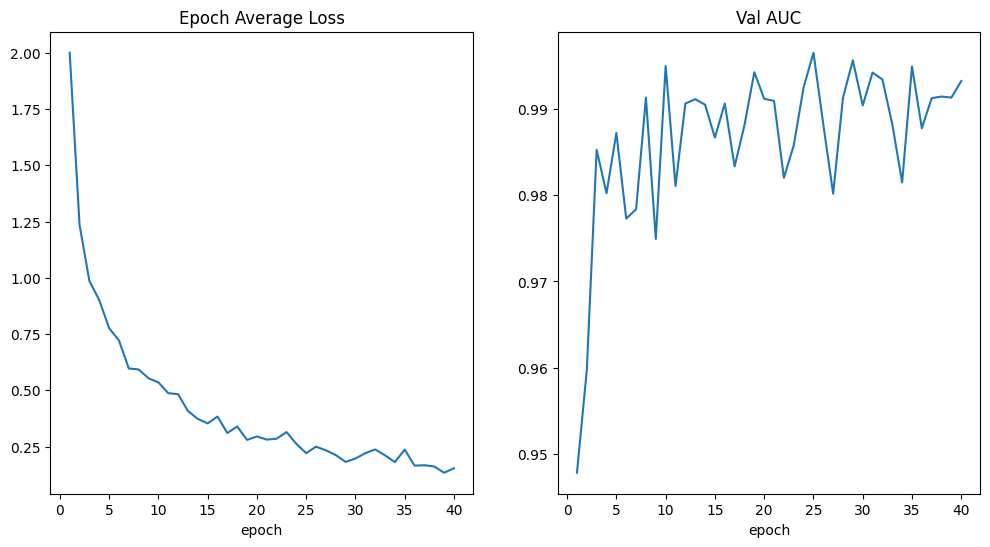

In [286]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [287]:
model.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_coronal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [288]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9718    1.0000    0.9857        69
           1     0.6000    0.4853    0.5366        68
           2     0.5385    0.6087    0.5714        69
           3     0.5114    0.6923    0.5882        65
           4     0.5111    0.3538    0.4182        65
           5     0.8955    0.9091    0.9023        66
           6     1.0000    0.9286    0.9630        28
           7     0.9500    0.9048    0.9268        21
           8     0.9524    0.9524    0.9524        21
           9     0.8732    0.8986    0.8857        69
          10     0.9265    0.9130    0.9197        69

    accuracy                         0.7574       610
   macro avg     0.7937    0.7860    0.7864       610
weighted avg     0.7585    0.7574    0.7539       610



In [289]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'coronal_full_pretrained_seed{seed}.csv')

## Unpretrained

In [290]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1
auc_metric = ROCAUCMetric()

In [291]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "coronal_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 1.7939
1


Epochs:   2%|▎         | 1/40 [00:17<11:26, 17.61s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9659 current accuracy: 0.6087 best AUC: 0.9659 at epoch: 1
----------
epoch 2/40
epoch 2 average loss: 1.1835
1


Epochs:   5%|▌         | 2/40 [00:34<11:02, 17.44s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9829 current accuracy: 0.7081 best AUC: 0.9829 at epoch: 2
----------
epoch 3/40
epoch 3 average loss: 0.9624


Epochs:   8%|▊         | 3/40 [00:52<10:40, 17.30s/it]

1
current epoch: 3 current AUC: 0.9782 current accuracy: 0.7391 best AUC: 0.9829 at epoch: 2
----------
epoch 4/40
epoch 4 average loss: 0.8472


Epochs:  10%|█         | 4/40 [01:09<10:22, 17.29s/it]

1
current epoch: 4 current AUC: 0.9775 current accuracy: 0.7453 best AUC: 0.9829 at epoch: 2
----------
epoch 5/40
epoch 5 average loss: 0.7733
1


Epochs:  12%|█▎        | 5/40 [01:26<10:08, 17.40s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9841 current accuracy: 0.8199 best AUC: 0.9841 at epoch: 5
----------
epoch 6/40
epoch 6 average loss: 0.6848
1


Epochs:  15%|█▌        | 6/40 [01:44<09:51, 17.39s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9862 current accuracy: 0.8447 best AUC: 0.9862 at epoch: 6
----------
epoch 7/40
epoch 7 average loss: 0.6827


Epochs:  18%|█▊        | 7/40 [02:01<09:32, 17.34s/it]

1
current epoch: 7 current AUC: 0.9789 current accuracy: 0.7888 best AUC: 0.9862 at epoch: 6
----------
epoch 8/40
epoch 8 average loss: 0.6112


Epochs:  20%|██        | 8/40 [02:18<09:16, 17.38s/it]

1
current epoch: 8 current AUC: 0.9839 current accuracy: 0.8137 best AUC: 0.9862 at epoch: 6
----------
epoch 9/40
epoch 9 average loss: 0.5149


Epochs:  22%|██▎       | 9/40 [02:35<08:53, 17.19s/it]

1
current epoch: 9 current AUC: 0.9841 current accuracy: 0.8012 best AUC: 0.9862 at epoch: 6
----------
epoch 10/40
epoch 10 average loss: 0.4821
1


Epochs:  25%|██▌       | 10/40 [02:53<08:38, 17.28s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9937 current accuracy: 0.8509 best AUC: 0.9937 at epoch: 10
----------
epoch 11/40
epoch 11 average loss: 0.4836
1


Epochs:  28%|██▊       | 11/40 [03:11<08:25, 17.43s/it]

saved new best metric model
current epoch: 11 current AUC: 0.9942 current accuracy: 0.8137 best AUC: 0.9942 at epoch: 11
----------
epoch 12/40
epoch 12 average loss: 0.4582


Epochs:  30%|███       | 12/40 [03:28<08:06, 17.39s/it]

1
current epoch: 12 current AUC: 0.9836 current accuracy: 0.8261 best AUC: 0.9942 at epoch: 11
----------
epoch 13/40
epoch 13 average loss: 0.4506


Epochs:  32%|███▎      | 13/40 [03:45<07:48, 17.34s/it]

1
current epoch: 13 current AUC: 0.9918 current accuracy: 0.8261 best AUC: 0.9942 at epoch: 11
----------
epoch 14/40
epoch 14 average loss: 0.3649


Epochs:  35%|███▌      | 14/40 [04:02<07:30, 17.31s/it]

1
current epoch: 14 current AUC: 0.9893 current accuracy: 0.8509 best AUC: 0.9942 at epoch: 11
----------
epoch 15/40
epoch 15 average loss: 0.3297


Epochs:  38%|███▊      | 15/40 [04:19<07:11, 17.27s/it]

1
current epoch: 15 current AUC: 0.9921 current accuracy: 0.8758 best AUC: 0.9942 at epoch: 11
----------
epoch 16/40
epoch 16 average loss: 0.3323


Epochs:  40%|████      | 16/40 [04:36<06:51, 17.16s/it]

1
current epoch: 16 current AUC: 0.9910 current accuracy: 0.8199 best AUC: 0.9942 at epoch: 11
----------
epoch 17/40
epoch 17 average loss: 0.3033


Epochs:  42%|████▎     | 17/40 [04:54<06:36, 17.24s/it]

1
current epoch: 17 current AUC: 0.9848 current accuracy: 0.8075 best AUC: 0.9942 at epoch: 11
----------
epoch 18/40
epoch 18 average loss: 0.3119


Epochs:  45%|████▌     | 18/40 [05:11<06:18, 17.21s/it]

1
current epoch: 18 current AUC: 0.9866 current accuracy: 0.8261 best AUC: 0.9942 at epoch: 11
----------
epoch 19/40
epoch 19 average loss: 0.3428


Epochs:  48%|████▊     | 19/40 [05:28<06:01, 17.21s/it]

1
current epoch: 19 current AUC: 0.9904 current accuracy: 0.8385 best AUC: 0.9942 at epoch: 11
----------
epoch 20/40
epoch 20 average loss: 0.2829


Epochs:  50%|█████     | 20/40 [05:45<05:44, 17.21s/it]

1
current epoch: 20 current AUC: 0.9851 current accuracy: 0.8385 best AUC: 0.9942 at epoch: 11
----------
epoch 21/40
epoch 21 average loss: 0.2783


Epochs:  52%|█████▎    | 21/40 [06:02<05:25, 17.12s/it]

1
current epoch: 21 current AUC: 0.9886 current accuracy: 0.8261 best AUC: 0.9942 at epoch: 11
----------
epoch 22/40
epoch 22 average loss: 0.2645


Epochs:  55%|█████▌    | 22/40 [06:20<05:09, 17.20s/it]

1
current epoch: 22 current AUC: 0.9864 current accuracy: 0.8261 best AUC: 0.9942 at epoch: 11
----------
epoch 23/40
epoch 23 average loss: 0.2205


Epochs:  57%|█████▊    | 23/40 [06:37<04:53, 17.24s/it]

1
current epoch: 23 current AUC: 0.9911 current accuracy: 0.8509 best AUC: 0.9942 at epoch: 11
----------
epoch 24/40
epoch 24 average loss: 0.2291


Epochs:  60%|██████    | 24/40 [06:54<04:35, 17.19s/it]

1
current epoch: 24 current AUC: 0.9903 current accuracy: 0.8571 best AUC: 0.9942 at epoch: 11
----------
epoch 25/40
epoch 25 average loss: 0.2022


Epochs:  62%|██████▎   | 25/40 [07:11<04:17, 17.16s/it]

1
current epoch: 25 current AUC: 0.9869 current accuracy: 0.8385 best AUC: 0.9942 at epoch: 11
----------
epoch 26/40
epoch 26 average loss: 0.1919


Epochs:  65%|██████▌   | 26/40 [07:28<03:59, 17.13s/it]

1
current epoch: 26 current AUC: 0.9938 current accuracy: 0.8571 best AUC: 0.9942 at epoch: 11
----------
epoch 27/40
epoch 27 average loss: 0.2080


Epochs:  68%|██████▊   | 27/40 [07:45<03:42, 17.15s/it]

1
current epoch: 27 current AUC: 0.9926 current accuracy: 0.8758 best AUC: 0.9942 at epoch: 11
----------
epoch 28/40
epoch 28 average loss: 0.2220


Epochs:  70%|███████   | 28/40 [08:03<03:26, 17.18s/it]

1
current epoch: 28 current AUC: 0.9882 current accuracy: 0.8385 best AUC: 0.9942 at epoch: 11
----------
epoch 29/40
epoch 29 average loss: 0.1955


Epochs:  72%|███████▎  | 29/40 [08:20<03:09, 17.19s/it]

1
current epoch: 29 current AUC: 0.9918 current accuracy: 0.8509 best AUC: 0.9942 at epoch: 11
----------
epoch 30/40
epoch 30 average loss: 0.1945


Epochs:  75%|███████▌  | 30/40 [08:37<02:52, 17.29s/it]

1
current epoch: 30 current AUC: 0.9940 current accuracy: 0.8944 best AUC: 0.9942 at epoch: 11
----------
epoch 31/40
epoch 31 average loss: 0.1710


Epochs:  78%|███████▊  | 31/40 [08:55<02:35, 17.26s/it]

1
current epoch: 31 current AUC: 0.9941 current accuracy: 0.8199 best AUC: 0.9942 at epoch: 11
----------
epoch 32/40
epoch 32 average loss: 0.1393


Epochs:  80%|████████  | 32/40 [09:12<02:17, 17.21s/it]

1
current epoch: 32 current AUC: 0.9879 current accuracy: 0.8820 best AUC: 0.9942 at epoch: 11
----------
epoch 33/40
epoch 33 average loss: 0.1952


Epochs:  82%|████████▎ | 33/40 [09:29<02:00, 17.17s/it]

1
current epoch: 33 current AUC: 0.9917 current accuracy: 0.9006 best AUC: 0.9942 at epoch: 11
----------
epoch 34/40
epoch 34 average loss: 0.1547


Epochs:  85%|████████▌ | 34/40 [09:46<01:42, 17.16s/it]

1
current epoch: 34 current AUC: 0.9879 current accuracy: 0.8882 best AUC: 0.9942 at epoch: 11
----------
epoch 35/40
epoch 35 average loss: 0.1633


Epochs:  88%|████████▊ | 35/40 [10:03<01:25, 17.14s/it]

1
current epoch: 35 current AUC: 0.9916 current accuracy: 0.8758 best AUC: 0.9942 at epoch: 11
----------
epoch 36/40
epoch 36 average loss: 0.1357


Epochs:  90%|█████████ | 36/40 [10:20<01:08, 17.16s/it]

1
current epoch: 36 current AUC: 0.9832 current accuracy: 0.8758 best AUC: 0.9942 at epoch: 11
----------
epoch 37/40
epoch 37 average loss: 0.1401


Epochs:  92%|█████████▎| 37/40 [10:37<00:51, 17.18s/it]

1
current epoch: 37 current AUC: 0.9883 current accuracy: 0.8447 best AUC: 0.9942 at epoch: 11
----------
epoch 38/40
epoch 38 average loss: 0.1511


Epochs:  95%|█████████▌| 38/40 [10:55<00:34, 17.17s/it]

1
current epoch: 38 current AUC: 0.9877 current accuracy: 0.8447 best AUC: 0.9942 at epoch: 11
----------
epoch 39/40
epoch 39 average loss: 0.1556


Epochs:  98%|█████████▊| 39/40 [11:12<00:17, 17.23s/it]

1
current epoch: 39 current AUC: 0.9931 current accuracy: 0.8385 best AUC: 0.9942 at epoch: 11
----------
epoch 40/40
epoch 40 average loss: 0.1393


Epochs: 100%|██████████| 40/40 [11:29<00:00, 17.24s/it]

1
current epoch: 40 current AUC: 0.9917 current accuracy: 0.8385 best AUC: 0.9942 at epoch: 11
train completed, best_metric: 0.9942 at epoch: 11


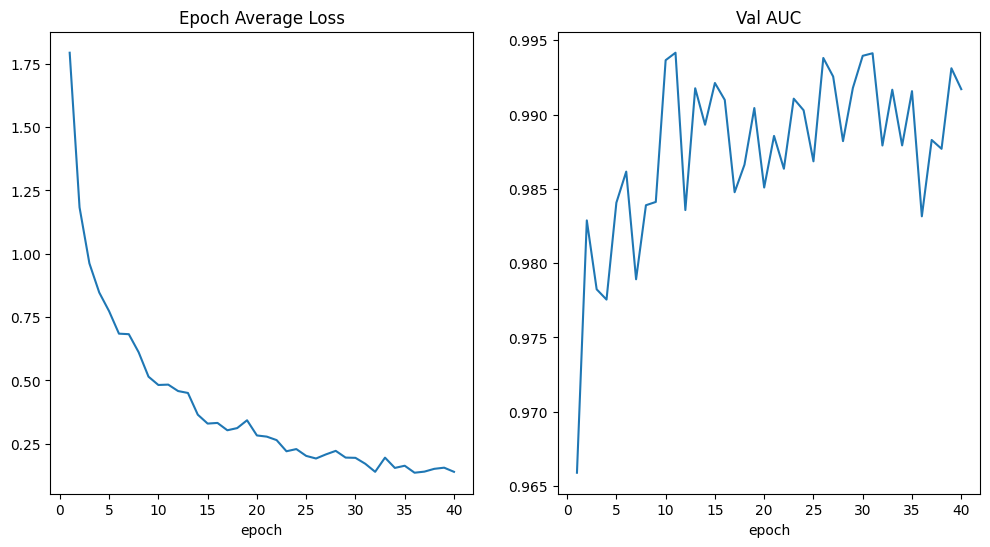

In [292]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [293]:
model.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [294]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.3500    0.2029    0.2569        69
           1     0.1579    0.1324    0.1440        68
           2     0.1064    0.0725    0.0862        69
           3     0.5172    0.2308    0.3191        65
           4     0.5789    0.1692    0.2619        65
           5     0.5062    0.6212    0.5578        66
           6     0.0000    0.0000    0.0000        28
           7     0.2857    0.3810    0.3265        21
           8     0.3478    0.3810    0.3636        21
           9     0.2340    0.4783    0.3143        69
          10     0.1773    0.3623    0.2381        69

    accuracy                         0.2770       610
   macro avg     0.2965    0.2756    0.2608       610
weighted avg     0.3091    0.2770    0.2634       610



In [295]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'coronal_full_unpretrained_seed{seed}.csv')

## Training cycle for the sagittal part

## Pretrained

In [296]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [297]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "sagittal_full_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 2.1196
1


Epochs:   2%|▎         | 1/40 [00:17<11:23, 17.52s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9179 current accuracy: 0.5155 best AUC: 0.9179 at epoch: 1
----------
epoch 2/40
epoch 2 average loss: 1.3459
1


Epochs:   5%|▌         | 2/40 [00:35<11:07, 17.56s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9701 current accuracy: 0.7081 best AUC: 0.9701 at epoch: 2
----------
epoch 3/40
epoch 3 average loss: 1.1052
1


Epochs:   8%|▊         | 3/40 [00:52<10:49, 17.56s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9838 current accuracy: 0.8137 best AUC: 0.9838 at epoch: 3
----------
epoch 4/40
epoch 4 average loss: 0.8689
1


Epochs:  10%|█         | 4/40 [01:10<10:30, 17.51s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9925 current accuracy: 0.8634 best AUC: 0.9925 at epoch: 4
----------
epoch 5/40
epoch 5 average loss: 0.7794


Epochs:  12%|█▎        | 5/40 [01:27<10:07, 17.36s/it]

1
current epoch: 5 current AUC: 0.9824 current accuracy: 0.8323 best AUC: 0.9925 at epoch: 4
----------
epoch 6/40
epoch 6 average loss: 0.7003


Epochs:  15%|█▌        | 6/40 [01:44<09:45, 17.23s/it]

1
current epoch: 6 current AUC: 0.9814 current accuracy: 0.7888 best AUC: 0.9925 at epoch: 4
----------
epoch 7/40
epoch 7 average loss: 0.6664


Epochs:  18%|█▊        | 7/40 [02:00<09:21, 17.02s/it]

1
current epoch: 7 current AUC: 0.9829 current accuracy: 0.7764 best AUC: 0.9925 at epoch: 4
----------
epoch 8/40
epoch 8 average loss: 0.6178


Epochs:  20%|██        | 8/40 [02:17<09:04, 17.00s/it]

1
current epoch: 8 current AUC: 0.9910 current accuracy: 0.8758 best AUC: 0.9925 at epoch: 4
----------
epoch 9/40
epoch 9 average loss: 0.5263


Epochs:  22%|██▎       | 9/40 [02:34<08:47, 17.02s/it]

1
current epoch: 9 current AUC: 0.9881 current accuracy: 0.8571 best AUC: 0.9925 at epoch: 4
----------
epoch 10/40
epoch 10 average loss: 0.5009


Epochs:  25%|██▌       | 10/40 [02:51<08:30, 17.01s/it]

1
current epoch: 10 current AUC: 0.9917 current accuracy: 0.8571 best AUC: 0.9925 at epoch: 4
----------
epoch 11/40
epoch 11 average loss: 0.4664
1


Epochs:  28%|██▊       | 11/40 [03:09<08:16, 17.13s/it]

saved new best metric model
current epoch: 11 current AUC: 0.9941 current accuracy: 0.9317 best AUC: 0.9941 at epoch: 11
----------
epoch 12/40
epoch 12 average loss: 0.4563
1


Epochs:  30%|███       | 12/40 [03:26<08:03, 17.26s/it]

saved new best metric model
current epoch: 12 current AUC: 0.9950 current accuracy: 0.8882 best AUC: 0.9950 at epoch: 12
----------
epoch 13/40
epoch 13 average loss: 0.4446


Epochs:  32%|███▎      | 13/40 [03:43<07:43, 17.15s/it]

1
current epoch: 13 current AUC: 0.9851 current accuracy: 0.8261 best AUC: 0.9950 at epoch: 12
----------
epoch 14/40
epoch 14 average loss: 0.4380


Epochs:  35%|███▌      | 14/40 [04:00<07:24, 17.10s/it]

1
current epoch: 14 current AUC: 0.9933 current accuracy: 0.8509 best AUC: 0.9950 at epoch: 12
----------
epoch 15/40
epoch 15 average loss: 0.3847
1


Epochs:  38%|███▊      | 15/40 [04:18<07:12, 17.31s/it]

saved new best metric model
current epoch: 15 current AUC: 0.9961 current accuracy: 0.9130 best AUC: 0.9961 at epoch: 15
----------
epoch 16/40
epoch 16 average loss: 0.3247
1


Epochs:  40%|████      | 16/40 [04:35<06:54, 17.27s/it]

saved new best metric model
current epoch: 16 current AUC: 0.9989 current accuracy: 0.9627 best AUC: 0.9989 at epoch: 16
----------
epoch 17/40
epoch 17 average loss: 0.3416


Epochs:  42%|████▎     | 17/40 [04:52<06:35, 17.20s/it]

1
current epoch: 17 current AUC: 0.9837 current accuracy: 0.8509 best AUC: 0.9989 at epoch: 16
----------
epoch 18/40
epoch 18 average loss: 0.3542


Epochs:  45%|████▌     | 18/40 [05:09<06:18, 17.19s/it]

1
current epoch: 18 current AUC: 0.9888 current accuracy: 0.8571 best AUC: 0.9989 at epoch: 16
----------
epoch 19/40
epoch 19 average loss: 0.3421


Epochs:  48%|████▊     | 19/40 [05:26<05:59, 17.13s/it]

1
current epoch: 19 current AUC: 0.9819 current accuracy: 0.8323 best AUC: 0.9989 at epoch: 16
----------
epoch 20/40
epoch 20 average loss: 0.2969


Epochs:  50%|█████     | 20/40 [05:43<05:42, 17.13s/it]

1
current epoch: 20 current AUC: 0.9896 current accuracy: 0.8634 best AUC: 0.9989 at epoch: 16
----------
epoch 21/40
epoch 21 average loss: 0.3229


Epochs:  52%|█████▎    | 21/40 [06:01<05:26, 17.17s/it]

1
current epoch: 21 current AUC: 0.9896 current accuracy: 0.8944 best AUC: 0.9989 at epoch: 16
----------
epoch 22/40
epoch 22 average loss: 0.2831


Epochs:  55%|█████▌    | 22/40 [06:18<05:09, 17.19s/it]

1
current epoch: 22 current AUC: 0.9923 current accuracy: 0.9068 best AUC: 0.9989 at epoch: 16
----------
epoch 23/40
epoch 23 average loss: 0.2795


Epochs:  57%|█████▊    | 23/40 [06:35<04:49, 17.02s/it]

1
current epoch: 23 current AUC: 0.9935 current accuracy: 0.9255 best AUC: 0.9989 at epoch: 16
----------
epoch 24/40
epoch 24 average loss: 0.2262


Epochs:  60%|██████    | 24/40 [06:52<04:33, 17.07s/it]

1
current epoch: 24 current AUC: 0.9987 current accuracy: 0.9441 best AUC: 0.9989 at epoch: 16
----------
epoch 25/40
epoch 25 average loss: 0.2548


Epochs:  62%|██████▎   | 25/40 [07:09<04:15, 17.03s/it]

1
current epoch: 25 current AUC: 0.9909 current accuracy: 0.8820 best AUC: 0.9989 at epoch: 16
----------
epoch 26/40
epoch 26 average loss: 0.2427


Epochs:  65%|██████▌   | 26/40 [07:26<03:58, 17.01s/it]

1
current epoch: 26 current AUC: 0.9833 current accuracy: 0.8199 best AUC: 0.9989 at epoch: 16
----------
epoch 27/40
epoch 27 average loss: 0.2039


Epochs:  68%|██████▊   | 27/40 [07:43<03:40, 16.99s/it]

1
current epoch: 27 current AUC: 0.9987 current accuracy: 0.9441 best AUC: 0.9989 at epoch: 16
----------
epoch 28/40
epoch 28 average loss: 0.2106


Epochs:  70%|███████   | 28/40 [08:00<03:24, 17.03s/it]

1
current epoch: 28 current AUC: 0.9937 current accuracy: 0.9006 best AUC: 0.9989 at epoch: 16
----------
epoch 29/40
epoch 29 average loss: 0.2169


Epochs:  72%|███████▎  | 29/40 [08:17<03:07, 17.05s/it]

1
current epoch: 29 current AUC: 0.9927 current accuracy: 0.8944 best AUC: 0.9989 at epoch: 16
----------
epoch 30/40
epoch 30 average loss: 0.1843


Epochs:  75%|███████▌  | 30/40 [08:34<02:50, 17.04s/it]

1
current epoch: 30 current AUC: 0.9963 current accuracy: 0.9130 best AUC: 0.9989 at epoch: 16
----------
epoch 31/40
epoch 31 average loss: 0.1705


Epochs:  78%|███████▊  | 31/40 [08:51<02:33, 17.11s/it]

1
current epoch: 31 current AUC: 0.9931 current accuracy: 0.8634 best AUC: 0.9989 at epoch: 16
----------
epoch 32/40
epoch 32 average loss: 0.1717


Epochs:  80%|████████  | 32/40 [09:08<02:16, 17.11s/it]

1
current epoch: 32 current AUC: 0.9956 current accuracy: 0.9068 best AUC: 0.9989 at epoch: 16
----------
epoch 33/40
epoch 33 average loss: 0.2104


Epochs:  82%|████████▎ | 33/40 [09:25<01:59, 17.11s/it]

1
current epoch: 33 current AUC: 0.9970 current accuracy: 0.9441 best AUC: 0.9989 at epoch: 16
----------
epoch 34/40
epoch 34 average loss: 0.1863


Epochs:  85%|████████▌ | 34/40 [09:43<01:43, 17.17s/it]

1
current epoch: 34 current AUC: 0.9925 current accuracy: 0.9068 best AUC: 0.9989 at epoch: 16
----------
epoch 35/40
epoch 35 average loss: 0.1854


Epochs:  88%|████████▊ | 35/40 [10:00<01:25, 17.14s/it]

1
current epoch: 35 current AUC: 0.9954 current accuracy: 0.9006 best AUC: 0.9989 at epoch: 16
----------
epoch 36/40
epoch 36 average loss: 0.1482


Epochs:  90%|█████████ | 36/40 [10:17<01:08, 17.08s/it]

1
current epoch: 36 current AUC: 0.9941 current accuracy: 0.9193 best AUC: 0.9989 at epoch: 16
----------
epoch 37/40
epoch 37 average loss: 0.1543


Epochs:  92%|█████████▎| 37/40 [10:34<00:51, 17.16s/it]

1
current epoch: 37 current AUC: 0.9956 current accuracy: 0.9193 best AUC: 0.9989 at epoch: 16
----------
epoch 38/40
epoch 38 average loss: 0.1871


Epochs:  95%|█████████▌| 38/40 [10:51<00:34, 17.17s/it]

1
current epoch: 38 current AUC: 0.9969 current accuracy: 0.9503 best AUC: 0.9989 at epoch: 16
----------
epoch 39/40
epoch 39 average loss: 0.1707


Epochs:  98%|█████████▊| 39/40 [11:08<00:17, 17.19s/it]

1
current epoch: 39 current AUC: 0.9935 current accuracy: 0.9193 best AUC: 0.9989 at epoch: 16
----------
epoch 40/40
epoch 40 average loss: 0.1570


Epochs: 100%|██████████| 40/40 [11:25<00:00, 17.15s/it]

1
current epoch: 40 current AUC: 0.9888 current accuracy: 0.8820 best AUC: 0.9989 at epoch: 16
train completed, best_metric: 0.9989 at epoch: 16


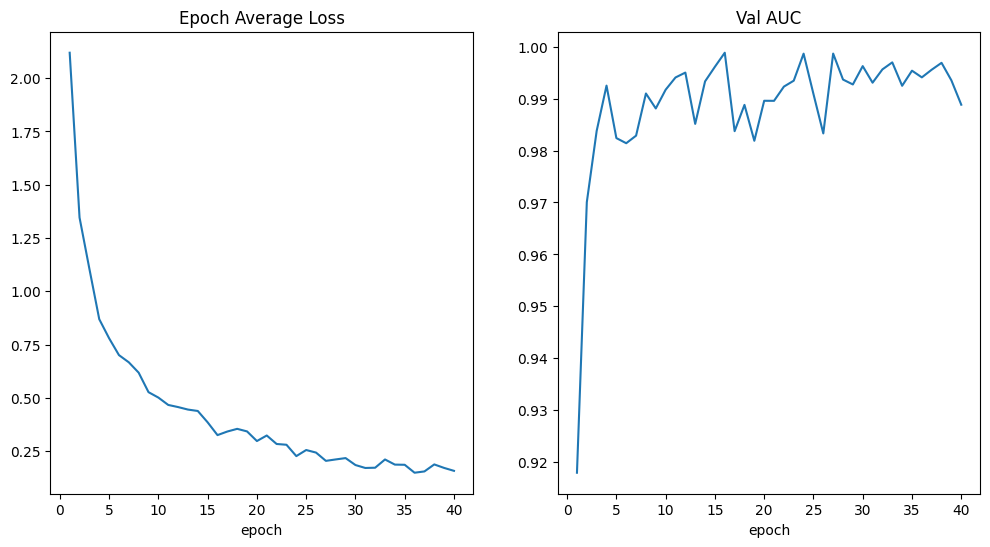

In [298]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [299]:
model.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_sagittal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [300]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        69
           1     0.6029    0.6029    0.6029        68
           2     0.5690    0.4783    0.5197        69
           3     0.5522    0.5692    0.5606        65
           4     0.5000    0.4615    0.4800        65
           5     0.7975    0.9545    0.8690        66
           6     0.9615    0.8929    0.9259        28
           7     0.9091    0.9524    0.9302        21
           8     0.8636    0.9048    0.8837        21
           9     0.7973    0.8551    0.8252        69
          10     0.9231    0.8696    0.8955        69

    accuracy                         0.7475       610
   macro avg     0.7706    0.7765    0.7721       610
weighted avg     0.7429    0.7475    0.7436       610



In [301]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'sagittal_full_pretrained_seed{seed}.csv')

## Unpretrained

In [302]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 40
val_interval = 1
auc_metric = ROCAUCMetric()

In [303]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "sagittal_full_unpretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

----------
epoch 1/40
epoch 1 average loss: 1.8623
1


Epochs:   2%|▎         | 1/40 [00:17<11:18, 17.40s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9739 current accuracy: 0.5342 best AUC: 0.9739 at epoch: 1
----------
epoch 2/40
epoch 2 average loss: 1.2681
1


Epochs:   5%|▌         | 2/40 [00:34<10:56, 17.27s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9904 current accuracy: 0.8882 best AUC: 0.9904 at epoch: 2
----------
epoch 3/40
epoch 3 average loss: 1.0200


Epochs:   8%|▊         | 3/40 [00:51<10:33, 17.12s/it]

1
current epoch: 3 current AUC: 0.9856 current accuracy: 0.6957 best AUC: 0.9904 at epoch: 2
----------
epoch 4/40
epoch 4 average loss: 0.8568


Epochs:  10%|█         | 4/40 [01:08<10:18, 17.18s/it]

1
current epoch: 4 current AUC: 0.9846 current accuracy: 0.8012 best AUC: 0.9904 at epoch: 2
----------
epoch 5/40
epoch 5 average loss: 0.7895


Epochs:  12%|█▎        | 5/40 [01:25<09:58, 17.10s/it]

1
current epoch: 5 current AUC: 0.9878 current accuracy: 0.7702 best AUC: 0.9904 at epoch: 2
----------
epoch 6/40
epoch 6 average loss: 0.7212


Epochs:  15%|█▌        | 6/40 [01:42<09:40, 17.09s/it]

1
current epoch: 6 current AUC: 0.9874 current accuracy: 0.7950 best AUC: 0.9904 at epoch: 2
----------
epoch 7/40
epoch 7 average loss: 0.6556


Epochs:  18%|█▊        | 7/40 [01:59<09:22, 17.05s/it]

1
current epoch: 7 current AUC: 0.9828 current accuracy: 0.7143 best AUC: 0.9904 at epoch: 2
----------
epoch 8/40
epoch 8 average loss: 0.5999
1


Epochs:  20%|██        | 8/40 [02:17<09:10, 17.22s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9923 current accuracy: 0.8758 best AUC: 0.9923 at epoch: 8
----------
epoch 9/40
epoch 9 average loss: 0.5918
1


Epochs:  22%|██▎       | 9/40 [02:34<08:56, 17.32s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9952 current accuracy: 0.8199 best AUC: 0.9952 at epoch: 9
----------
epoch 10/40
epoch 10 average loss: 0.5303


Epochs:  25%|██▌       | 10/40 [02:51<08:35, 17.19s/it]

1
current epoch: 10 current AUC: 0.9913 current accuracy: 0.8075 best AUC: 0.9952 at epoch: 9
----------
epoch 11/40
epoch 11 average loss: 0.5160


Epochs:  28%|██▊       | 11/40 [03:08<08:16, 17.10s/it]

1
current epoch: 11 current AUC: 0.9940 current accuracy: 0.8261 best AUC: 0.9952 at epoch: 9
----------
epoch 12/40
epoch 12 average loss: 0.4522


Epochs:  30%|███       | 12/40 [03:25<07:59, 17.12s/it]

1
current epoch: 12 current AUC: 0.9929 current accuracy: 0.8758 best AUC: 0.9952 at epoch: 9
----------
epoch 13/40
epoch 13 average loss: 0.4332


Epochs:  32%|███▎      | 13/40 [03:43<07:43, 17.17s/it]

1
current epoch: 13 current AUC: 0.9952 current accuracy: 0.8447 best AUC: 0.9952 at epoch: 9
----------
epoch 14/40
epoch 14 average loss: 0.4166
1


Epochs:  35%|███▌      | 14/40 [04:00<07:28, 17.26s/it]

saved new best metric model
current epoch: 14 current AUC: 0.9962 current accuracy: 0.8758 best AUC: 0.9962 at epoch: 14
----------
epoch 15/40
epoch 15 average loss: 0.3593


Epochs:  38%|███▊      | 15/40 [04:17<07:10, 17.22s/it]

1
current epoch: 15 current AUC: 0.9950 current accuracy: 0.8696 best AUC: 0.9962 at epoch: 14
----------
epoch 16/40
epoch 16 average loss: 0.3855
1


Epochs:  40%|████      | 16/40 [04:35<06:54, 17.27s/it]

saved new best metric model
current epoch: 16 current AUC: 0.9967 current accuracy: 0.9006 best AUC: 0.9967 at epoch: 16
----------
epoch 17/40
epoch 17 average loss: 0.3303


Epochs:  42%|████▎     | 17/40 [04:52<06:34, 17.17s/it]

1
current epoch: 17 current AUC: 0.9944 current accuracy: 0.8696 best AUC: 0.9967 at epoch: 16
----------
epoch 18/40
epoch 18 average loss: 0.3275


Epochs:  45%|████▌     | 18/40 [05:09<06:16, 17.10s/it]

1
current epoch: 18 current AUC: 0.9887 current accuracy: 0.8758 best AUC: 0.9967 at epoch: 16
----------
epoch 19/40
epoch 19 average loss: 0.2978


Epochs:  48%|████▊     | 19/40 [05:26<05:58, 17.07s/it]

1
current epoch: 19 current AUC: 0.9866 current accuracy: 0.8012 best AUC: 0.9967 at epoch: 16
----------
epoch 20/40
epoch 20 average loss: 0.2491


Epochs:  50%|█████     | 20/40 [05:42<05:40, 17.04s/it]

1
current epoch: 20 current AUC: 0.9916 current accuracy: 0.8882 best AUC: 0.9967 at epoch: 16
----------
epoch 21/40
epoch 21 average loss: 0.2652


Epochs:  52%|█████▎    | 21/40 [06:00<05:25, 17.15s/it]

1
current epoch: 21 current AUC: 0.9940 current accuracy: 0.8882 best AUC: 0.9967 at epoch: 16
----------
epoch 22/40
epoch 22 average loss: 0.3390


Epochs:  55%|█████▌    | 22/40 [06:17<05:09, 17.18s/it]

1
current epoch: 22 current AUC: 0.9820 current accuracy: 0.7950 best AUC: 0.9967 at epoch: 16
----------
epoch 23/40
epoch 23 average loss: 0.2641


Epochs:  57%|█████▊    | 23/40 [06:34<04:51, 17.17s/it]

1
current epoch: 23 current AUC: 0.9941 current accuracy: 0.8820 best AUC: 0.9967 at epoch: 16
----------
epoch 24/40
epoch 24 average loss: 0.2584


Epochs:  60%|██████    | 24/40 [06:51<04:34, 17.17s/it]

1
current epoch: 24 current AUC: 0.9936 current accuracy: 0.8820 best AUC: 0.9967 at epoch: 16
----------
epoch 25/40
epoch 25 average loss: 0.2391


Epochs:  62%|██████▎   | 25/40 [07:09<04:18, 17.21s/it]

1
current epoch: 25 current AUC: 0.9849 current accuracy: 0.7578 best AUC: 0.9967 at epoch: 16
----------
epoch 26/40
epoch 26 average loss: 0.2625


Epochs:  65%|██████▌   | 26/40 [07:26<03:59, 17.14s/it]

1
current epoch: 26 current AUC: 0.9947 current accuracy: 0.8758 best AUC: 0.9967 at epoch: 16
----------
epoch 27/40
epoch 27 average loss: 0.2221
1


Epochs:  68%|██████▊   | 27/40 [07:44<03:45, 17.36s/it]

saved new best metric model
current epoch: 27 current AUC: 0.9977 current accuracy: 0.9317 best AUC: 0.9977 at epoch: 27
----------
epoch 28/40
epoch 28 average loss: 0.2248


Epochs:  70%|███████   | 28/40 [08:01<03:28, 17.35s/it]

1
current epoch: 28 current AUC: 0.9963 current accuracy: 0.9006 best AUC: 0.9977 at epoch: 27
----------
epoch 29/40
epoch 29 average loss: 0.2092


Epochs:  72%|███████▎  | 29/40 [08:18<03:11, 17.38s/it]

1
current epoch: 29 current AUC: 0.9870 current accuracy: 0.8261 best AUC: 0.9977 at epoch: 27
----------
epoch 30/40
epoch 30 average loss: 0.2086


Epochs:  75%|███████▌  | 30/40 [08:36<02:53, 17.34s/it]

1
current epoch: 30 current AUC: 0.9952 current accuracy: 0.8820 best AUC: 0.9977 at epoch: 27
----------
epoch 31/40
epoch 31 average loss: 0.1768


Epochs:  78%|███████▊  | 31/40 [08:53<02:36, 17.37s/it]

1
current epoch: 31 current AUC: 0.9932 current accuracy: 0.8882 best AUC: 0.9977 at epoch: 27
----------
epoch 32/40
epoch 32 average loss: 0.1617


Epochs:  80%|████████  | 32/40 [09:10<02:18, 17.35s/it]

1
current epoch: 32 current AUC: 0.9937 current accuracy: 0.8634 best AUC: 0.9977 at epoch: 27
----------
epoch 33/40
epoch 33 average loss: 0.1569


Epochs:  82%|████████▎ | 33/40 [09:28<02:01, 17.39s/it]

1
current epoch: 33 current AUC: 0.9943 current accuracy: 0.8758 best AUC: 0.9977 at epoch: 27
----------
epoch 34/40
epoch 34 average loss: 0.1504


Epochs:  85%|████████▌ | 34/40 [09:45<01:44, 17.41s/it]

1
current epoch: 34 current AUC: 0.9945 current accuracy: 0.9068 best AUC: 0.9977 at epoch: 27
----------
epoch 35/40
epoch 35 average loss: 0.1575


Epochs:  88%|████████▊ | 35/40 [10:03<01:26, 17.36s/it]

1
current epoch: 35 current AUC: 0.9924 current accuracy: 0.8385 best AUC: 0.9977 at epoch: 27
----------
epoch 36/40
epoch 36 average loss: 0.1726


Epochs:  90%|█████████ | 36/40 [10:20<01:09, 17.37s/it]

1
current epoch: 36 current AUC: 0.9946 current accuracy: 0.8882 best AUC: 0.9977 at epoch: 27
----------
epoch 37/40
epoch 37 average loss: 0.1335


Epochs:  92%|█████████▎| 37/40 [10:37<00:52, 17.39s/it]

1
current epoch: 37 current AUC: 0.9905 current accuracy: 0.8571 best AUC: 0.9977 at epoch: 27
----------
epoch 38/40
epoch 38 average loss: 0.1325


Epochs:  95%|█████████▌| 38/40 [10:55<00:34, 17.35s/it]

1
current epoch: 38 current AUC: 0.9945 current accuracy: 0.9006 best AUC: 0.9977 at epoch: 27
----------
epoch 39/40
epoch 39 average loss: 0.1689


Epochs:  98%|█████████▊| 39/40 [11:12<00:17, 17.34s/it]

1
current epoch: 39 current AUC: 0.9925 current accuracy: 0.8882 best AUC: 0.9977 at epoch: 27
----------
epoch 40/40
epoch 40 average loss: 0.1581


Epochs: 100%|██████████| 40/40 [11:29<00:00, 17.24s/it]

1
current epoch: 40 current AUC: 0.9961 current accuracy: 0.9317 best AUC: 0.9977 at epoch: 27
train completed, best_metric: 0.9977 at epoch: 27


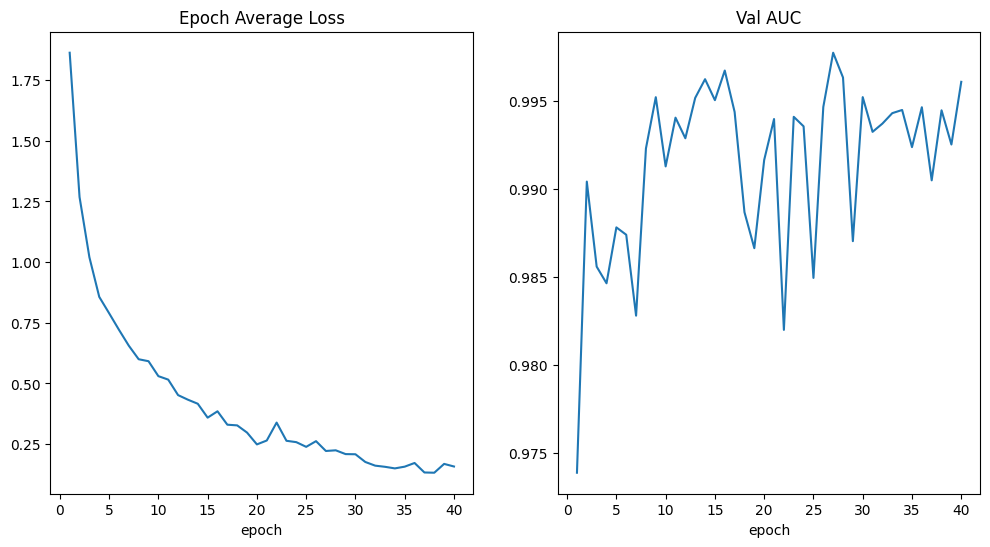

In [304]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [305]:
model.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [306]:
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9688    0.8986    0.9323        69
           1     0.5513    0.6324    0.5890        68
           2     0.4615    0.3478    0.3967        69
           3     0.3647    0.4769    0.4133        65
           4     0.3226    0.1538    0.2083        65
           5     0.7424    0.7424    0.7424        66
           6     0.6875    0.3929    0.5000        28
           7     0.9048    0.9048    0.9048        21
           8     0.5000    0.4286    0.4615        21
           9     0.5283    0.8116    0.6400        69
          10     0.5753    0.6087    0.5915        69

    accuracy                         0.5836       610
   macro avg     0.6007    0.5817    0.5800       610
weighted avg     0.5816    0.5836    0.5719       610



In [307]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'sagittal_full_unpretrained_seed{seed}.csv')

In [140]:
class Sliced_Dataset(Dataset):
    def __init__(self, dataset, slices=9, transform=None):
        self.dataset = dataset
        self.slices = slices
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        slices = self.slices

        if self.transform:
            data = self.transform(data)

        axial, coronal, sagittal = self.get_middle_slices(data, slices)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def get_middle_slices(data, slices):
        axial = data.permute(1, 0, 2, 3).flatten(0, 1)
        coronal = data.permute(2, 0, 1, 3).flatten(0, 1)
        sagittal = data.permute(3, 0, 1, 2).flatten(0, 1)
        
        return axial, coronal, sagittal

## Pretrained

In [141]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)


model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_axial.eval()

model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_coronal.eval()

model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))
model_sagittal.eval()

results = []

y_true = []
y_pred = []

train_dataset_ = Sliced_Dataset(train_dataset, transform=train_transforms)
val_dataset_ = Sliced_Dataset(val_dataset, transform=val_transforms)
test_dataset_ = Sliced_Dataset(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred_axial = model_axial(test_axial.to(device)).argmax(dim=1)
        pred_coronal = model_coronal(test_coronal.to(device)).argmax(dim=1)
        pred_sagittal = model_sagittal(test_sagittal.to(device)).argmax(dim=1)
        pred = torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)
        
        for i in range(pred.shape[1]):
            data = pred[:, i]
            counts = torch.bincount(data)
            most_frequent_value = torch.argmax(counts).item()
            
            y_true.append(test_labels[i].item())
            y_pred.append(most_frequent_value)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=info['label'], digits=4, output_dict=True)
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

df = pd.DataFrame(report).transpose()
df.to_csv(f'classification_results_pretrained_full_seed{seed}.csv')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


              precision    recall  f1-score   support

           0     0.8182    0.9130    0.8630        69
           1     0.4286    0.3529    0.3871        68
           2     0.3624    0.7826    0.4954        69
           3     0.4512    0.5692    0.5034        65
           4     0.4091    0.1385    0.2069        65
           5     0.9184    0.6818    0.7826        66
           6     0.8824    0.5357    0.6667        28
           7     1.0000    0.6190    0.7647        21
           8     0.7857    0.5238    0.6286        21
           9     0.7541    0.6667    0.7077        69
          10     0.8714    0.8841    0.8777        69

    accuracy                         0.6197       610
   macro avg     0.6983    0.6061    0.6258       610
weighted avg     0.6582    0.6197    0.6151       610



## Unpretrained

In [142]:
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_axial.eval()
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_coronal.eval()
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model_sagittal.eval()

results = []

for num_slices in range(3, 33, 3):  # Adjust the range based on your requirements
    y_true = []
    y_pred = []

    train_dataset_ = Sliced_Dataset(train_dataset, slices=num_slices, transform=train_transforms)
    val_dataset_ = Sliced_Dataset(val_dataset, slices=num_slices, transform=val_transforms)
    test_dataset_ = Sliced_Dataset(test_dataset, slices=num_slices, transform=test_transforms)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)
    
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data['images'],
                test_data['label'][:, 0].type(torch.LongTensor).to(device),
            )
            test_axial, test_coronal, test_sagittal = test_images
            for i in range(num_slices//3):
                pred_axial = model_axial(test_axial[i].to(device)).argmax(dim=1)
                pred_coronal = model_coronal(test_coronal[i].to(device)).argmax(dim=1)
                pred_sagittal = model_sagittal(test_sagittal[i].to(device)).argmax(dim=1)
                if i != 0:
                    pred = torch.cat((pred, torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)))
                else:
                    pred = torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)
            
            for i in range(pred.shape[1]):
                data = pred[:, i]
                counts = torch.bincount(data)
                most_frequent_value = torch.argmax(counts).item()
                
                y_true.append(test_labels[i].item())
                y_pred.append(most_frequent_value)

    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    selected_metrics = {
        "num_slices": num_slices,
        "accuracy": report["accuracy"],
    }
    results.append(selected_metrics)

# Combine all results into a single DataFrame
final_results = pd.DataFrame(results, index = None)

# Save to CSV or analyze further
final_results.to_csv("classification_results_unpretrained_3_channels.csv", index=False)
print(final_results)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 64, 64, 64] to have 3 channels, but got 64 channels instead

# Using 2d models as a backbone

In [308]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))

<All keys matched successfully>

In [309]:
class CombinedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        # Assuming each model outputs a 512-dimension feature vector (from ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):

        axial = x[:, 0].to(torch.float32)
        coronal = x[:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal = x[:, 0].permute(0, 3, 1, 2).to(torch.float32)

        axial_features = self.model_axial(axial)  # Output: [batch_size, 512, 1, 1]
        coronal_features = self.model_coronal(coronal)
        sagittal_features = self.model_sagittal(sagittal)

        axial_features = axial_features.view(axial_features.size(0), -1)  # [batch_size, 512]
        coronal_features = coronal_features.view(coronal_features.size(0), -1)
        sagittal_features = sagittal_features.view(sagittal_features.size(0), -1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

## Evaluation on a 3d dataset

In [310]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [311]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [312]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [313]:
for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.1033627525452645
Epoch 2, Loss: 1.6505484273356776
Epoch 3, Loss: 1.3507240779938237
Epoch 4, Loss: 1.1092119620692344
Epoch 5, Loss: 0.9522701751801276
Epoch 6, Loss: 0.8317619715967486
Epoch 7, Loss: 0.7260254929142613
Epoch 8, Loss: 0.6542891090916049
Epoch 9, Loss: 0.6035136782353924
Epoch 10, Loss: 0.5549309445965674
Epoch 11, Loss: 0.514348094501803
Epoch 12, Loss: 0.4775156340291423
Epoch 13, Loss: 0.4597750315743108
Epoch 14, Loss: 0.4226092013620561
Epoch 15, Loss: 0.40175740757296163
Epoch 16, Loss: 0.38478787531775815
Epoch 17, Loss: 0.38725509662781993
Epoch 18, Loss: 0.36802136753835984
Epoch 19, Loss: 0.33942457504810825
Epoch 20, Loss: 0.33373274293638044
Epoch 21, Loss: 0.317584240628827
Epoch 22, Loss: 0.3078102522319363
Epoch 23, Loss: 0.293994769934685
Epoch 24, Loss: 0.292564106564368
Epoch 25, Loss: 0.29487856645737925
Epoch 26, Loss: 0.2760501648149183
Epoch 27, Loss: 0.2685028391499673
Epoch 28, Loss: 0.259696233176416
Epoch 29, Loss: 0.272028730

In [314]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 1.0000


In [315]:
combined_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = combined_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9900


In [316]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9857    1.0000    0.9928        69
           1     0.7167    0.6324    0.6719        68
           2     0.7000    0.7101    0.7050        69
           3     0.7534    0.8462    0.7971        65
           4     0.7966    0.7231    0.7581        65
           5     0.8806    0.8939    0.8872        66
           6     1.0000    0.8214    0.9020        28
           7     0.9545    1.0000    0.9767        21
           8     1.0000    1.0000    1.0000        21
           9     0.8611    0.8986    0.8794        69
          10     0.8904    0.9420    0.9155        69

    accuracy                         0.8426       610
   macro avg     0.8672    0.8607    0.8623       610
weighted avg     0.8423    0.8426    0.8411       610



In [317]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'combined_unpretrained_full_seed{seed}.csv')

## Pretrained

In [318]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [319]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [320]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [321]:
for epoch in tqdm(range(30), desc="Epochs"):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|▎         | 1/30 [00:01<00:40,  1.40s/it]

Epoch 1, Loss: 2.3580391676195207


Epochs:   7%|▋         | 2/30 [00:02<00:39,  1.40s/it]

Epoch 2, Loss: 1.8809703665394937


Epochs:  10%|█         | 3/30 [00:04<00:37,  1.40s/it]

Epoch 3, Loss: 1.5476489566987561


Epochs:  13%|█▎        | 4/30 [00:05<00:36,  1.41s/it]

Epoch 4, Loss: 1.2925570895594936


Epochs:  17%|█▋        | 5/30 [00:07<00:35,  1.41s/it]

Epoch 5, Loss: 1.0896867686702358


Epochs:  20%|██        | 6/30 [00:08<00:33,  1.40s/it]

Epoch 6, Loss: 0.959179045692567


Epochs:  23%|██▎       | 7/30 [00:09<00:32,  1.40s/it]

Epoch 7, Loss: 0.8623610427302699


Epochs:  27%|██▋       | 8/30 [00:11<00:30,  1.40s/it]

Epoch 8, Loss: 0.7834618187719776


Epochs:  30%|███       | 9/30 [00:12<00:29,  1.40s/it]

Epoch 9, Loss: 0.7114873220843654


Epochs:  33%|███▎      | 10/30 [00:14<00:28,  1.40s/it]

Epoch 10, Loss: 0.6574507365303655


Epochs:  37%|███▋      | 11/30 [00:15<00:26,  1.41s/it]

Epoch 11, Loss: 0.5945886210087807


Epochs:  40%|████      | 12/30 [00:16<00:25,  1.40s/it]

Epoch 12, Loss: 0.5772804127585504


Epochs:  43%|████▎     | 13/30 [00:18<00:23,  1.40s/it]

Epoch 13, Loss: 0.5203766140245623


Epochs:  47%|████▋     | 14/30 [00:19<00:22,  1.40s/it]

Epoch 14, Loss: 0.5129263199144795


Epochs:  50%|█████     | 15/30 [00:21<00:21,  1.40s/it]

Epoch 15, Loss: 0.49965019860575277


Epochs:  53%|█████▎    | 16/30 [00:22<00:19,  1.40s/it]

Epoch 16, Loss: 0.46846577044456233


Epochs:  57%|█████▋    | 17/30 [00:23<00:18,  1.40s/it]

Epoch 17, Loss: 0.4449159945211103


Epochs:  60%|██████    | 18/30 [00:25<00:16,  1.40s/it]

Epoch 18, Loss: 0.43230386751313366


Epochs:  63%|██████▎   | 19/30 [00:26<00:15,  1.40s/it]

Epoch 19, Loss: 0.42641349377170684


Epochs:  67%|██████▋   | 20/30 [00:28<00:14,  1.40s/it]

Epoch 20, Loss: 0.4015945167310776


Epochs:  70%|███████   | 21/30 [00:29<00:12,  1.40s/it]

Epoch 21, Loss: 0.3794033916727189


Epochs:  73%|███████▎  | 22/30 [00:30<00:11,  1.40s/it]

Epoch 22, Loss: 0.37515406454763106


Epochs:  77%|███████▋  | 23/30 [00:32<00:09,  1.40s/it]

Epoch 23, Loss: 0.36944352811382664


Epochs:  80%|████████  | 24/30 [00:33<00:08,  1.40s/it]

Epoch 24, Loss: 0.36374365706597606


Epochs:  83%|████████▎ | 25/30 [00:35<00:07,  1.40s/it]

Epoch 25, Loss: 0.34683855262494856


Epochs:  87%|████████▋ | 26/30 [00:36<00:05,  1.40s/it]

Epoch 26, Loss: 0.36505440935011835


Epochs:  90%|█████████ | 27/30 [00:37<00:04,  1.40s/it]

Epoch 27, Loss: 0.31463796236822683


Epochs:  93%|█████████▎| 28/30 [00:39<00:02,  1.40s/it]

Epoch 28, Loss: 0.31899819571164345


Epochs:  97%|█████████▋| 29/30 [00:40<00:01,  1.40s/it]

Epoch 29, Loss: 0.31603198041838987


Epochs: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]

Epoch 30, Loss: 0.31116877496242523


In [322]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9989, Accuracy: 14.7391


In [323]:
combined_model.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = combined_model(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9866


In [324]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict=True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9851    0.9565    0.9706        69
           1     0.7885    0.6029    0.6833        68
           2     0.8367    0.5942    0.6949        69
           3     0.6829    0.8615    0.7619        65
           4     0.8065    0.7692    0.7874        65
           5     0.7273    0.8485    0.7832        66
           6     1.0000    0.8214    0.9020        28
           7     1.0000    0.9524    0.9756        21
           8     1.0000    1.0000    1.0000        21
           9     0.8451    0.8696    0.8571        69
          10     0.7907    0.9855    0.8774        69

    accuracy                         0.8230       610
   macro avg     0.8602    0.8420    0.8449       610
weighted avg     0.8311    0.8230    0.8200       610



In [325]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'combined_pretrained_full_seed{seed}.csv')

## Weighted concatenation

In [326]:
class HyperNetwork(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=11):
        super(HyperNetwork, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])
        
        # Hypernetwork for weighting the features
        self.hyper_fc = nn.Sequential(
            nn.Linear(512 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 512 * 3),
            nn.Sigmoid()
        )
        
        # Final classification layer
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, x):

        axial = x[:, 0].to(torch.float32)
        coronal = x[:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal = x[:, 0].permute(0, 3, 1, 2).to(torch.float32)
        
        features_axial = self.model_axial(axial).flatten(1)
        features_coronal = self.model_coronal(coronal).flatten(1)
        features_sagittal = self.model_sagittal(sagittal).flatten(1)
        
        combined_features = torch.cat([features_axial, features_coronal, features_sagittal], dim=1)
        
        # Apply hypernetwork to decide weights
        weights = self.hyper_fc(combined_features)
        combined_weighted_features = combined_features * weights
        
        # Final classification
        out = self.fc(combined_weighted_features)
        return out

In [327]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [328]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [329]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=64, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_unpretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_unpretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_unpretrained.pth"), weights_only=True))

<All keys matched successfully>

In [330]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [331]:
for epoch in tqdm(range(30), desc="Epochs"):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(torch.float32).to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|▎         | 1/30 [00:01<00:55,  1.91s/it]

Epoch 1, Loss: 2.344564537848196


Epochs:   7%|▋         | 2/30 [00:03<00:53,  1.91s/it]

Epoch 2, Loss: 2.06607517503923


Epochs:  10%|█         | 3/30 [00:05<00:51,  1.91s/it]

Epoch 3, Loss: 1.8387740850448608


Epochs:  13%|█▎        | 4/30 [00:07<00:49,  1.91s/it]

Epoch 4, Loss: 1.653283461447685


Epochs:  17%|█▋        | 5/30 [00:09<00:47,  1.91s/it]

Epoch 5, Loss: 1.4920074247544812


Epochs:  20%|██        | 6/30 [00:11<00:45,  1.91s/it]

Epoch 6, Loss: 1.3490151320734332


Epochs:  23%|██▎       | 7/30 [00:13<00:43,  1.91s/it]

Epoch 7, Loss: 1.2340665786497054


Epochs:  27%|██▋       | 8/30 [00:15<00:42,  1.91s/it]

Epoch 8, Loss: 1.1248556510094674


Epochs:  30%|███       | 9/30 [00:17<00:40,  1.91s/it]

Epoch 9, Loss: 1.0392780573137346


Epochs:  33%|███▎      | 10/30 [00:19<00:38,  1.91s/it]

Epoch 10, Loss: 0.9595759857085443


Epochs:  37%|███▋      | 11/30 [00:21<00:36,  1.91s/it]

Epoch 11, Loss: 0.9007222902390265


Epochs:  40%|████      | 12/30 [00:22<00:34,  1.91s/it]

Epoch 12, Loss: 0.8458407232838292


Epochs:  43%|████▎     | 13/30 [00:24<00:32,  1.91s/it]

Epoch 13, Loss: 0.790751168804784


Epochs:  47%|████▋     | 14/30 [00:26<00:30,  1.91s/it]

Epoch 14, Loss: 0.7373160642962302


Epochs:  50%|█████     | 15/30 [00:28<00:28,  1.91s/it]

Epoch 15, Loss: 0.7137343172104128


Epochs:  53%|█████▎    | 16/30 [00:30<00:26,  1.91s/it]

Epoch 16, Loss: 0.6673978240259232


Epochs:  57%|█████▋    | 17/30 [00:32<00:24,  1.91s/it]

Epoch 17, Loss: 0.630024395642742


Epochs:  60%|██████    | 18/30 [00:34<00:22,  1.91s/it]

Epoch 18, Loss: 0.6212743501509389


Epochs:  63%|██████▎   | 19/30 [00:36<00:21,  1.91s/it]

Epoch 19, Loss: 0.5971777967868312


Epochs:  67%|██████▋   | 20/30 [00:38<00:19,  1.91s/it]

Epoch 20, Loss: 0.5662057688159328


Epochs:  70%|███████   | 21/30 [00:40<00:17,  1.91s/it]

Epoch 21, Loss: 0.5484196043783619


Epochs:  73%|███████▎  | 22/30 [00:42<00:15,  1.91s/it]

Epoch 22, Loss: 0.5244206065131772


Epochs:  77%|███████▋  | 23/30 [00:43<00:13,  1.91s/it]

Epoch 23, Loss: 0.5049365691600307


Epochs:  80%|████████  | 24/30 [00:45<00:11,  1.91s/it]

Epoch 24, Loss: 0.47745015063593466


Epochs:  83%|████████▎ | 25/30 [00:47<00:09,  1.91s/it]

Epoch 25, Loss: 0.47427298561219244


Epochs:  87%|████████▋ | 26/30 [00:49<00:07,  1.91s/it]

Epoch 26, Loss: 0.4517399418738581


Epochs:  90%|█████████ | 27/30 [00:51<00:05,  1.91s/it]

Epoch 27, Loss: 0.44346177481835886


Epochs:  93%|█████████▎| 28/30 [00:53<00:03,  1.92s/it]

Epoch 28, Loss: 0.44761577152436777


Epochs:  97%|█████████▋| 29/30 [00:55<00:01,  1.92s/it]

Epoch 29, Loss: 0.42824290452464936


Epochs: 100%|██████████| 30/30 [00:57<00:00,  1.91s/it]

Epoch 30, Loss: 0.4023969567591144


In [332]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(torch.float32).to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric = ROCAUCMetric()
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9996


In [333]:
hypernetwork.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = hypernetwork(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Test AUC: {result:.4f}")

Test AUC: 0.9877


In [334]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict = True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9857    1.0000    0.9928        69
           1     0.6901    0.7206    0.7050        68
           2     0.7143    0.6522    0.6818        69
           3     0.7467    0.8615    0.8000        65
           4     0.8868    0.7231    0.7966        65
           5     0.8594    0.8333    0.8462        66
           6     1.0000    0.8214    0.9020        28
           7     1.0000    1.0000    1.0000        21
           8     0.9545    1.0000    0.9767        21
           9     0.8696    0.8696    0.8696        69
          10     0.8228    0.9420    0.8784        69

    accuracy                         0.8377       610
   macro avg     0.8664    0.8567    0.8590       610
weighted avg     0.8409    0.8377    0.8369       610



In [335]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'weighted_unpretrained_full_seed{seed}.csv')

## Pretrained

In [336]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "axial_full_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "coronal_full_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "sagittal_full_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [337]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [338]:
for epoch in tqdm(range(30), desc="Epochs"):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(torch.float32).to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epochs:   3%|▎         | 1/30 [00:01<00:40,  1.38s/it]

Epoch 1, Loss: 2.3254740161280476


Epochs:   7%|▋         | 2/30 [00:02<00:38,  1.38s/it]

Epoch 2, Loss: 2.053143205181245


Epochs:  10%|█         | 3/30 [00:04<00:37,  1.38s/it]

Epoch 3, Loss: 1.8241487703015726


Epochs:  13%|█▎        | 4/30 [00:05<00:35,  1.38s/it]

Epoch 4, Loss: 1.6425728067275016


Epochs:  17%|█▋        | 5/30 [00:06<00:34,  1.38s/it]

Epoch 5, Loss: 1.481622907423204


Epochs:  20%|██        | 6/30 [00:08<00:33,  1.38s/it]

Epoch 6, Loss: 1.3458971823415449


Epochs:  23%|██▎       | 7/30 [00:09<00:31,  1.38s/it]

Epoch 7, Loss: 1.2310427773383357


Epochs:  27%|██▋       | 8/30 [00:11<00:30,  1.38s/it]

Epoch 8, Loss: 1.1290474553262033


Epochs:  30%|███       | 9/30 [00:12<00:28,  1.38s/it]

Epoch 9, Loss: 1.0478500608474977


Epochs:  33%|███▎      | 10/30 [00:13<00:27,  1.38s/it]

Epoch 10, Loss: 0.9660566872166049


Epochs:  37%|███▋      | 11/30 [00:15<00:26,  1.38s/it]

Epoch 11, Loss: 0.9043828998842547


Epochs:  40%|████      | 12/30 [00:16<00:24,  1.38s/it]

Epoch 12, Loss: 0.8435533412041203


Epochs:  43%|████▎     | 13/30 [00:17<00:23,  1.38s/it]

Epoch 13, Loss: 0.8167649795932155


Epochs:  47%|████▋     | 14/30 [00:19<00:22,  1.38s/it]

Epoch 14, Loss: 0.7756700900293165


Epochs:  50%|█████     | 15/30 [00:20<00:20,  1.38s/it]

Epoch 15, Loss: 0.7289708295176106


Epochs:  53%|█████▎    | 16/30 [00:22<00:19,  1.39s/it]

Epoch 16, Loss: 0.6916268525585052


Epochs:  57%|█████▋    | 17/30 [00:23<00:18,  1.39s/it]

Epoch 17, Loss: 0.6702794836413476


Epochs:  60%|██████    | 18/30 [00:24<00:16,  1.39s/it]

Epoch 18, Loss: 0.6237969946476721


Epochs:  63%|██████▎   | 19/30 [00:26<00:15,  1.39s/it]

Epoch 19, Loss: 0.6057494003926555


Epochs:  67%|██████▋   | 20/30 [00:27<00:13,  1.38s/it]

Epoch 20, Loss: 0.6011300759930764


Epochs:  70%|███████   | 21/30 [00:29<00:12,  1.38s/it]

Epoch 21, Loss: 0.5731131742077489


Epochs:  73%|███████▎  | 22/30 [00:30<00:11,  1.38s/it]

Epoch 22, Loss: 0.5600404268310916


Epochs:  77%|███████▋  | 23/30 [00:31<00:09,  1.38s/it]

Epoch 23, Loss: 0.5424015570071435


Epochs:  80%|████████  | 24/30 [00:33<00:08,  1.39s/it]

Epoch 24, Loss: 0.5324184144696882


Epochs:  83%|████████▎ | 25/30 [00:34<00:06,  1.39s/it]

Epoch 25, Loss: 0.5248037903539596


Epochs:  87%|████████▋ | 26/30 [00:35<00:05,  1.38s/it]

Epoch 26, Loss: 0.4973929822444916


Epochs:  90%|█████████ | 27/30 [00:37<00:04,  1.38s/it]

Epoch 27, Loss: 0.473958529772297


Epochs:  93%|█████████▎| 28/30 [00:38<00:02,  1.38s/it]

Epoch 28, Loss: 0.4610592617142585


Epochs:  97%|█████████▋| 29/30 [00:40<00:01,  1.38s/it]

Epoch 29, Loss: 0.4692617212572405


Epochs: 100%|██████████| 30/30 [00:41<00:00,  1.38s/it]

Epoch 30, Loss: 0.45444726943969727


In [339]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(torch.float32).to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9987, Accuracy: 14.7516


In [340]:
hypernetwork.eval()
y_true = []
y_predicted = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for test_data in test_loader_3d:
        test_images, test_labels = test_data

        output = hypernetwork(test_images.to(device))
        pred = output.argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_predicted.append(pred[i].item())

        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    print(f"Validation AUC: {result:.4f}")

Validation AUC: 0.9864


In [341]:
report = classification_report(y_true, y_predicted, target_names=info['label'], digits=4, output_dict = True)
report.update({"AUC": f"{result:.4f}"})
print(classification_report(y_true, y_predicted, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9855    0.9855    0.9855        69
           1     0.7885    0.6029    0.6833        68
           2     0.8333    0.6522    0.7317        69
           3     0.7778    0.8615    0.8175        65
           4     0.8305    0.7538    0.7903        65
           5     0.6860    0.8939    0.7763        66
           6     1.0000    0.8214    0.9020        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    0.9524    0.9756        21
           9     0.8986    0.8986    0.8986        69
          10     0.8000    0.9855    0.8831        69

    accuracy                         0.8393       610
   macro avg     0.8727    0.8553    0.8585       610
weighted avg     0.8461    0.8393    0.8367       610



In [342]:
df = pd.DataFrame(report).transpose()
df.to_csv(f'weighted_pretrained_full_seed{seed}.csv')